In [1]:
import os
import sys

base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts')
sys.path.insert(1, base_path)

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from helpers import *
import networkx as nx
from utils import remove_top_right_frame, jitter_scatterplot
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from tqdm import tqdm



main_dir = r'/home/arashsm79/Playground/EPFL/cellular'
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'Figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'Data')

fname = 'data_bio482.pkl'

Main working directory: /home/arashsm79/Playground/EPFL/cellular


In [19]:
data_df = pd.read_pickle(os.path.join(data_path, fname))

# Free Whisking Windows

(2000,)
[ 9.382 10.392 11.182 12.862]


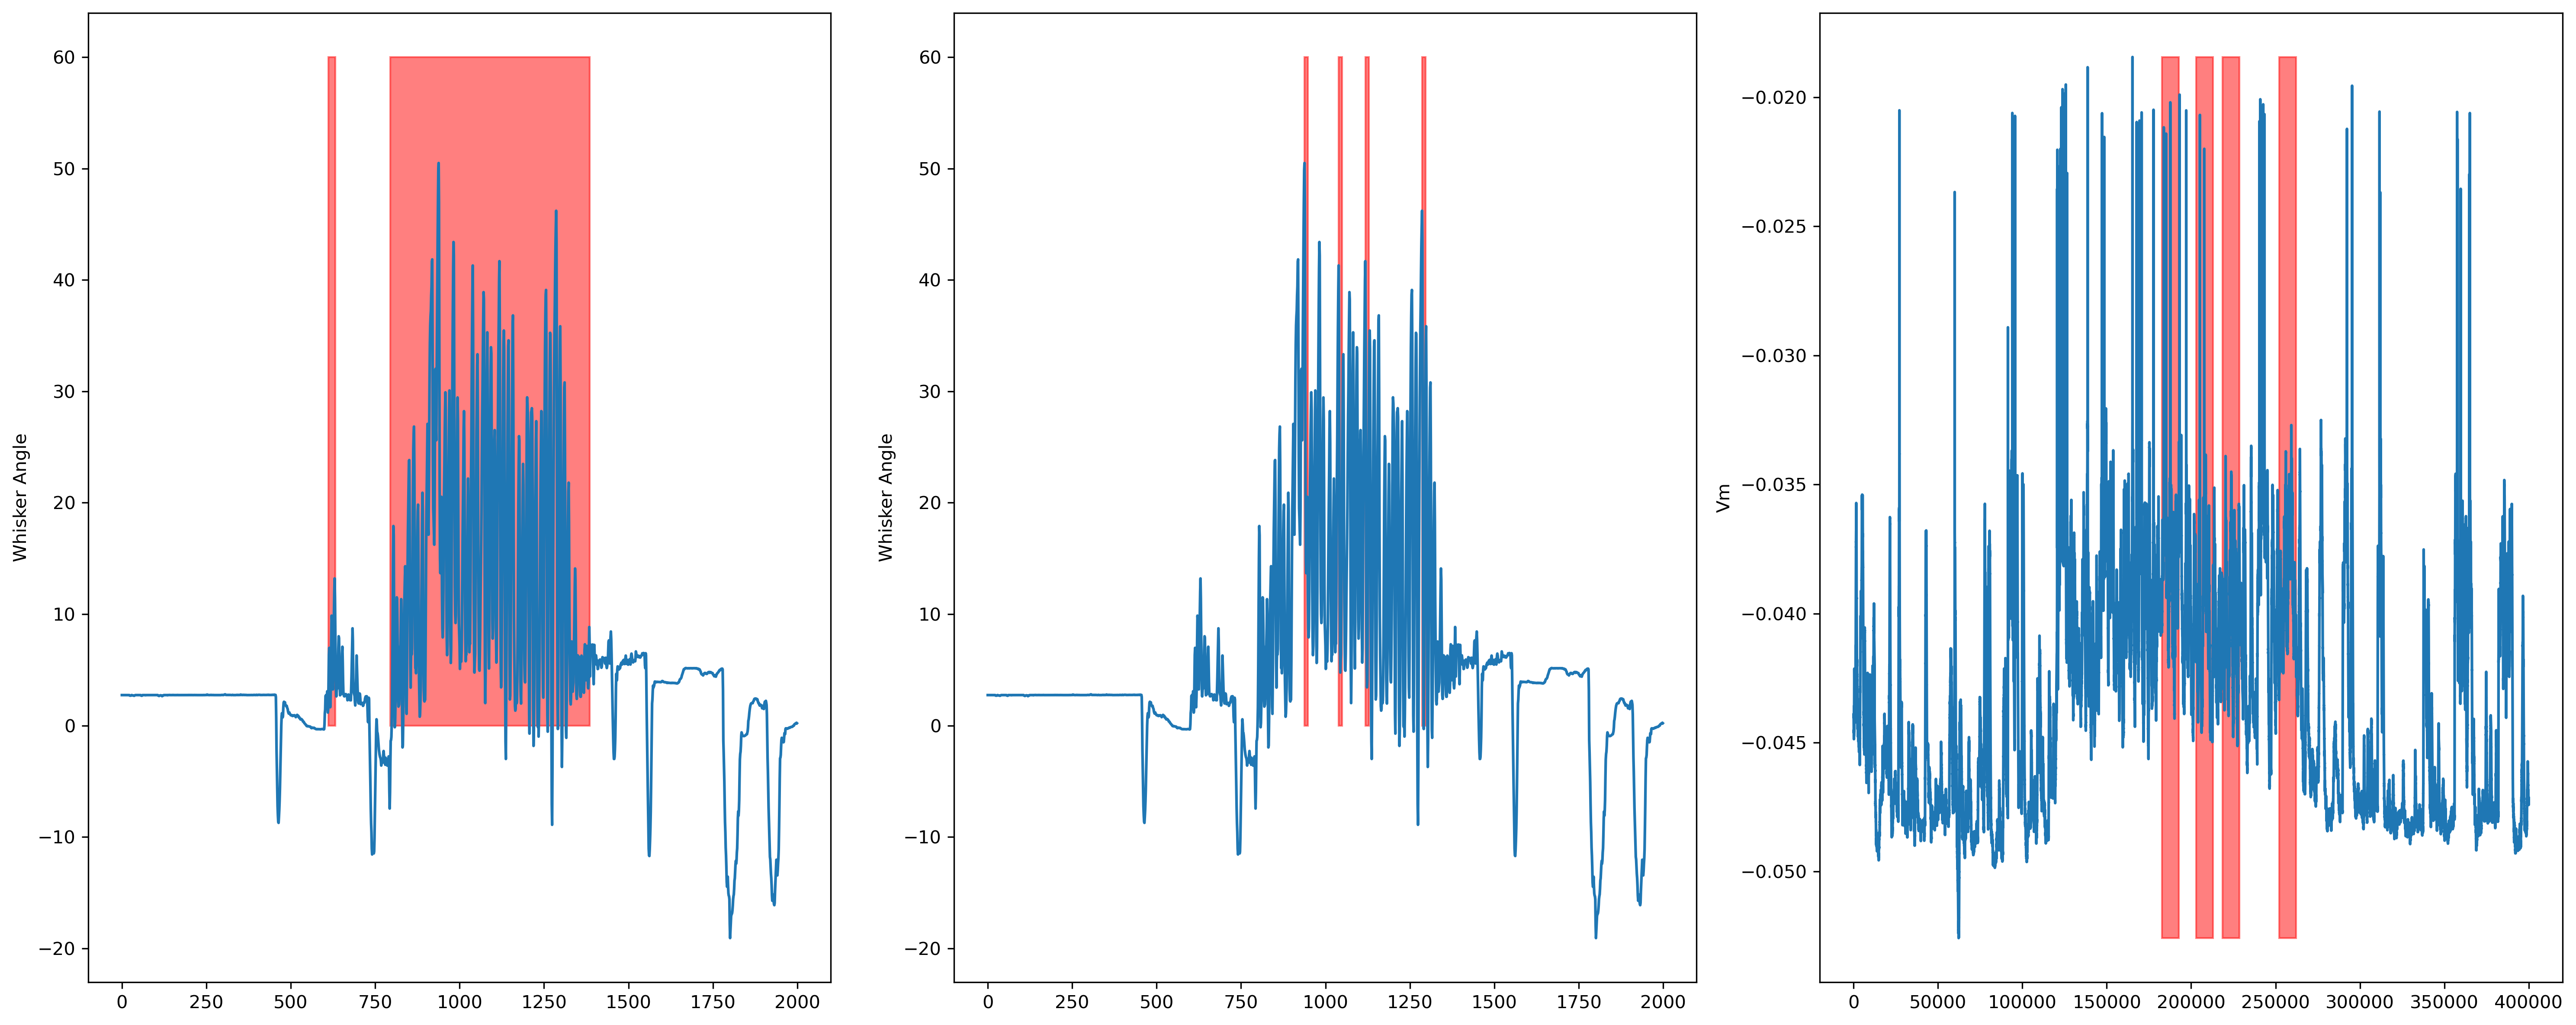

In [3]:
row = data_df.iloc[0] #free whjickinmg trial
print(row["Sweep_WhiskerAngle"].shape)
wp = row["Sweep_WhiskerAngle"]
vm = row["Sweep_MembranePotential"]
event_times = row['Sweep_WhiskingTimes'] #in sec

from scipy.signal import find_peaks
thr = 40
min_dist = 50

event_on = np.array([])
for on, off in event_times:
    if off - on < 1: #enigh lage windows
        continue
    peaks, _ = find_peaks(wp[int(on * 100) :int(off *100)], height = thr, distance = min_dist)
    #print(peaks)
    event_on = np.array(list(event_on) + list(peaks + on * 100))

pre_window = 0.25 # time before whisking onset (s)
post_window = 0.25 # time after whisking onset (s)
min_event_dur = 0.2 # minimal duration of whisking episode to be considered
min_iti = 0.5 # minimal intertrial interval (ITI) between 2 consecutive whisking episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.05 # bin size for psth (s)
epoch_bounds = {'pre':[-0.5, -0.3],
                  'post':[0,0.2]}  # time boundaries to compute changes in whisker protraction (WP), or Vm

event_on_time = event_on / 100 #TIME
print(event_on_time)

l = [ [x-pre_window, x+post_window] for x in event_on_time] 


fig, a = plt.subplots(1,3, dpi=300, figsize=(20,8))

a[0].plot(wp)
a[0].set_ylabel("Whisker Angle")
for on, off in event_times:
    width = (off - on ) * 100
    a[0].add_patch(plt.Rectangle((on * 100, 0), width, 60, color="red", alpha=0.5))

a[1].plot(wp)
a[1].set_ylabel("Whisker Angle")
for on in event_on:
    width = 10
    a[1].add_patch(plt.Rectangle((on, 0), width, 60, color="red", alpha=0.5))

a[2].plot(vm)
a[2].set_ylabel("Vm")
for on, off in l:
    width = (off - on ) * 20000
    a[2].add_patch(plt.Rectangle((on * 20000, np.min(vm)), width, np.abs(np.min(vm)-np.max(vm)), color="red", alpha=0.5))

plt.tight_layout()
plt.savefig("FW_peaks_exctraction.png")

# Active Touch Windows

In [ ]:
row = data_df.iloc[0] #free whjickinmg trial
print(row["Sweep_WhiskerAngle"].shape)
wp = row["Sweep_WhiskerAngle"]
vm = row["Sweep_MembranePotential"]
event_times = row['Sweep_ActiveContactTimes'] #in sec

print('event times', event_times)
from scipy.signal import find_peaks
thr = 40
min_dist = 50

event_on = np.array([])
for on, off in event_times:
    if off - on < 1: #enigh lage windows
        continue
    peaks, _ = find_peaks(wp[int(on * 100) :int(off *100)], height = thr, distance = min_dist)
    #print(peaks)
    event_on = np.array(list(event_on) + list(peaks + on * 100))

pre_window = 0.25 # time before whisking onset (s)
post_window = 0.25 # time after whisking onset (s)
min_event_dur = 0.2 # minimal duration of whisking episode to be considered
min_iti = 0.5 # minimal intertrial interval (ITI) between 2 consecutive whisking episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.05 # bin size for psth (s)
epoch_bounds = {'pre':[-0.5, -0.3],
                  'post':[0,0.2]}  # time boundaries to compute changes in whisker protraction (WP), or Vm

event_on_time = event_on / 100 #TIME
print(event_on_time)

l = [ [x-pre_window, x+post_window] for x in event_on_time] 


fig, a = plt.subplots(1,1, dpi=300, figsize=(20,5))

a.plot(wp)
a.set_ylabel("Whisker Angle")
for on, off in event_times:
    width = (off - on ) * 100
    a.add_patch(plt.Rectangle((on * 100, 0), width, 60, color="red", alpha=0.5))
    a.set_xlim(500, 1300)

plt.tight_layout()

In [ ]:
def Function_Select_PeakProtractions(WP, event_times, threshold, distance):
    """Selects the peak protractions from the whisker angle signal.

    Parameters
    ----------
    WP : np.ndarray
        whisker angle signal
    event_times : np.ndarray
        event times
    threshold : float
        threshold for peak detection
    min_distance : int
        minimum distance between peaks

    Returns
    ------- 
    peaks : np.ndarray
        peak protractions
    """

    all_peaks = []
    if event_times is None:
        return None
    if len(event_times.shape) == 1:
        event_times = event_times[None]
    if type(event_times[0][0]) == np.ndarray:
        event_times = event_times[0]

    for i, event in enumerate(event_times):
        event_dur = event[1] - event[0]

        if event_dur > 0.01:
            # get index of event, fr = 100 Hz
            pt1 = int(np.floor(event[0] * 100))
            pt2 = int(np.floor(event[1] * 100))

            WP_seg = WP[pt1:pt2]

            # find the peaks
            peaks, _ = find_peaks(WP_seg, height=threshold, distance=distance)

            if peaks.shape[0] > 0:
                # concatenate the peaks times to all_peaks. convert to seconds
                for pt in peaks:
                    all_peaks.append(pt / 100 + event[0])

    l = [ [x-0.001, x+0.001] for x in all_peaks] 

    return np.array(l) #RETURN PEAKS WINDOWS IN SECONDS

# PARAMETERS
1) window size 0.5 sec (0.25+025)
2) min time between event 0.5
3) free whiskinf treshoudl (angle) --> 20

In [ ]:
pre_window = 0.25 # time before touch onset (s)
post_window = 0.25 # time after touch onset (s)

min_event_dur = 0 # minimal duration of active touch episode to be considered
min_iti = pre_window + post_window # minimal intertrial interval (ITI) between 2 consecutive touch episode (s)

min_peak_threshold = 20

epoch_bounds = {'pre':[-pre_window, 0],
                  'post':[0,post_window]}  # time boundaries to compute changes in whisker protraction (WP), or Vm

### FREE WHICKSING

In [ ]:
sweep_type = 'free whisking'

data_df_subset = data_df[data_df['Sweep_Type']==sweep_type] 

all_cells = np.unique(data_df_subset.Cell_ID)
print('Number of cells:', len(all_cells))

result_dict = {'cell_id': [np.nan], 
                  'cell_type':[np.nan], 
                  'vm_amplitude_pre': [np.nan],
                  'vm_amplitude_post': [np.nan],
                  'ap_fr_pre':[np.nan],
                  'ap_fr_post':[np.nan],
                  'fft_low':[np.nan],
                  'fft_high':[np.nan],            
                  'vm_mav_pre': [np.nan],
                  'vm_mav_post': [np.nan],
                  'vm_max_pre': [np.nan],
                  'vm_max_post': [np.nan],
                  'vm_std_pre': [np.nan],
                  'vm_std_post': [np.nan],
                  'vm_rms_pre': [np.nan],
                  'vm_rms_post': [np.nan],
                  'vm_wl_pre': [np.nan],
                  'vm_wl_post': [np.nan],
                  'vm_ssc_pre': [np.nan],
                  'vm_ssc_post': [np.nan]
                }
df = pd.DataFrame(result_dict)
    
# Iterate over each cell identities to collect desired data
for idx, cell in enumerate(np.unique(data_df_subset.Cell_ID)):

    if idx%10==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))
    
    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])
    
    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]
    
    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values #all the list of sweeps
 
    ## For that cell, iterate over trials
    for trial in trial_list:
        
        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]
        
        sr_wp = cell_trial_df['Sweep_WhiskerAngle_SamplingRate'].values[0] #[0] to get the content of the array
        # Get event times for that trial
        event_times = Function_Select_PeakProtractions(cell_trial_df["Sweep_WhiskerAngle"].values[0],cell_trial_df['Sweep_WhiskingTimes'].values[0], threshold=min_peak_threshold, distance=min_iti*sr_wp)
        
        if event_times is None or len(event_times) == 0: 
            continue
        
        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]
        
         # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        
        # Detection of action potentials for that trial, and update total number of APs for that cell
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh) 
                
        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)
             #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
            #For APs, make an analog binary vector of same dimensions as Vm_Sub
            vec_length = len(vm_sub)
            ap_vect = Function_Times2Vect(ap_peak_times, sr_vm, vec_length)     
        # Else if no AP, subthreshold Vm is just Vm
        else:
            vm_sub = membrane_potential.copy()
            ap_vect = np.zeros_like(vm_sub) #empty vector of size Vm_Sub

        # time * events
        vm_event = Function_Event_Triggered_Signal(vm_sub, sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, -np.inf)
        ap_event = Function_Event_Triggered_Signal(np.squeeze(ap_vect), sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, -np.inf)
        
        if type(vm_event) == int:
            continue
        if type(ap_event) == int:
            continue


        if vm_event.shape[1] != ap_event.shape[1] or vm_event.shape[1] == 0:
            continue

        for event_vm, event_ap in zip(vm_event.T, ap_event.T): #TTENTION TRABSPOSE

            result_dict = {'cell_id': np.nan, 
                              'cell_type':np.nan, 
                              'vm_amplitude_pre': np.nan,
                              'vm_amplitude_post': np.nan,
                              'ap_fr_pre':np.nan,
                              'ap_fr_post':np.nan,
                              'vm_mav_pre': np.nan,
                              'vm_mav_post': np.nan,
                              'vm_max_pre': np.nan,
                              'vm_max_post': np.nan,
                              'vm_std_pre': np.nan,
                              'vm_std_post': np.nan,
                              'vm_rms_pre': np.nan,
                              'vm_rms_post': np.nan,
                              'vm_wl_pre': np.nan,
                              'vm_wl_post': np.nan,
                              'vm_ssc_pre': np.nan,
                              'vm_ssc_post': np.nan,
                            }
            
            for epoch in epoch_bounds.keys():
                bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_vm)) #sr_vm !
                bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_vm-1))
                
                if epoch=='pre':
                    sub_vm_in_event = event_vm[bound_1:bound_2]
                    result_dict['vm_amplitude_pre'] = sub_vm_in_event.mean(0) * 1000 #in mV!
                    result_dict['ap_fr_pre'] = event_ap[bound_1:bound_2].mean(0) * sr_vm       #in Hz!
                    result_dict['vm_ssc_pre'] = np.sum(np.diff(np.sign(np.diff(sub_vm_in_event))) != 0)
                    result_dict['vm_wl_pre'] = np.sum(np.abs(np.diff(sub_vm_in_event))) 
                    result_dict['vm_rms_pre'] = np.sqrt(np.mean(np.square(sub_vm_in_event)))
                    result_dict['vm_std_pre'] = np.std(sub_vm_in_event)
                    result_dict['vm_max_pre'] = np.max(np.abs(sub_vm_in_event))
                    result_dict['vm_mav_pre'] = np.mean(np.abs(sub_vm_in_event))

                else:
                    sub_vm_in_event = event_vm[bound_1:bound_2]
                    result_dict['vm_amplitude_post'] = sub_vm_in_event.mean(0) * 1000 #in Hz!
                    result_dict['ap_fr_post'] = event_ap[bound_1:bound_2].mean(0) * sr_vm
                    result_dict['vm_ssc_post'] = np.sum(np.diff(np.sign(np.diff(sub_vm_in_event))) != 0)
                    result_dict['vm_wl_post'] = np.sum(np.abs(np.diff(sub_vm_in_event))) 
                    result_dict['vm_rms_post'] = np.sqrt(np.mean(np.square(sub_vm_in_event)))
                    result_dict['vm_std_post'] = np.std(sub_vm_in_event)
                    result_dict['vm_max_post'] = np.max(np.abs(sub_vm_in_event))
                    result_dict['vm_mav_post'] = np.mean(np.abs(sub_vm_in_event))


            result_dict["cell_id"] = cell
            result_dict["cell_type"] = cell_df.Cell_Type.values[0] 

            #FFT
            time_window = 2
            freq_band_lim = [1, 10, 30, 90]
            fft = Function_Compute_FFTs(event_vm, sr_vm, time_window)
            warnings.filterwarnings("ignore", message="nperseg = .* is greater than input length .*") #TO STOP WARNINGS

            # We need to find which point (sample) in the FFT correspond to which frequency
            # TRNASFORM FREQ. LIMINTS INTO RTNAGE ON X AXIS FOR FFT COMPUTED
            pt1 = int(freq_band_lim[0] * fft.shape[0] / (sr_vm/2) ) + 1 #1Hz into FFT point
            pt2 = int(freq_band_lim[1] * fft.shape[0] / (sr_vm/2) ) + 1 #int: slicing requires integers
            result_dict['fft_low'] = fft[pt1:pt2].mean() #THEY CREATE THE MENA, NOT INTERTS IN THE PLOT (ANDAMNMTO )
            
            pt3 = int(freq_band_lim[2] * fft.shape[0] / (sr_vm/2) ) + 1
            pt4 = int(freq_band_lim[3] * fft.shape[0] / (sr_vm/2) ) + 1 
            result_dict['fft_high'] = fft[pt3:pt4].mean()

            #df = df.append(result_dict, ignore_index=True)
            df.loc[len(df)] = result_dict


print('Done!')
warnings.resetwarnings()

fw_df = df.copy()
fw_df.head()

Number of cells: 232
Cell 0/232
Cell 10/232
Cell 20/232
Cell 30/232


/home/arashsm79/.miniforge3/envs/compneuro/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 40000 is greater than input length  = 10000, using nperseg = 10000
  warnings.warn('nperseg = {0:d} is greater than input length '


Cell 40/232


/home/arashsm79/Playground/EPFL/cellular/src/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


Cell 50/232
Cell 60/232
Cell 70/232
Cell 80/232
Cell 90/232
Cell 100/232
Cell 110/232
Cell 120/232


/home/arashsm79/Playground/EPFL/cellular/src/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


Cell 130/232
Cell 140/232
Cell 150/232
Cell 160/232
Cell 170/232
Cell 180/232
Cell 190/232
Cell 200/232
Cell 210/232
Cell 220/232
Cell 230/232
Done!


cell_id cell_type  vm_amplitude_pre  vm_amplitude_post  ap_fr_pre  \
0      NaN       NaN               NaN                NaN        NaN   
1  JP902_1       EXC        -55.079505         -52.166831     0.0000   
2  JP902_1       EXC        -53.711890         -53.938270     0.0000   
3  JP902_1       EXC        -51.899546         -55.655256    12.0024   
4  JP902_1       EXC        -50.540924         -49.494906     0.0000   

   ap_fr_post   fft_low  fft_high  vm_mav_pre  vm_mav_post  vm_max_pre  \
0         NaN       NaN       NaN         NaN          NaN         NaN   
1      4.0008  0.000604  0.000084    0.055080     0.052167    0.059650   
2      4.0008  0.000638  0.000092    0.053712     0.053938    0.059122   
3      0.0000  0.000447  0.000108    0.051900     0.055655    0.058428   
4      8.0016  0.000901  0.000133    0.050541     0.049495    0.057859   

   vm_max_post  vm_std_pre  vm_std_post  vm_rms_pre  vm_rms_post  vm_wl_pre  \
0          NaN         NaN          NaN         NaN          NaN        NaN   
1     0.057188    0.002453     0.003497    0.234690     0.228401   0.147459   
2     0.057997    0.003029     0.003262    0.231758     0.232246   0.151866   
3     0.060759    0.005038     0.002812    0.227815     0.235914   0.176212   
4     0.056591    0.003468     0.003942    0.224813     0.222475   0.157647   

   vm_wl_post  vm_ssc_pre  vm_ssc_post  
0         NaN         NaN          NaN  
1    0.151719      2879.0       2698.0  
2    0.165975      2902.0       2653.0  
3    0.156675      2472.0       2774.0  
4    0.160081      2698.0       2485.0

In [10]:
len(fw_df)

4910

### ACTIVE TOUCH

In [11]:
sweep_type = 'active touch'

data_df_subset = data_df[data_df['Sweep_Type']==sweep_type] 

all_cells = np.unique(data_df_subset.Cell_ID)
print('Number of cells:', len(all_cells))

verbose=0 #set to 0 to hide individual AP plots

result_dict = {'cell_id': [np.nan], 
                  'cell_type':[np.nan], 
                  'vm_amplitude_pre': [np.nan],
                  'vm_amplitude_post': [np.nan],
                  'ap_fr_pre':[np.nan],
                  'ap_fr_post':[np.nan],
                  'fft_low':[np.nan],
                  'fft_high':[np.nan],            
                  'vm_mav_pre': [np.nan],
                  'vm_mav_post': [np.nan],
                  'vm_max_pre': [np.nan],
                  'vm_max_post': [np.nan],
                  'vm_std_pre': [np.nan],
                  'vm_std_post': [np.nan],
                  'vm_rms_pre': [np.nan],
                  'vm_rms_post': [np.nan],
                  'vm_wl_pre': [np.nan],
                  'vm_wl_post': [np.nan],
                  'vm_ssc_pre': [np.nan],
                  'vm_ssc_post': [np.nan]
                }

df = pd.DataFrame(result_dict)
    
# Iterate over each cell identities to collect desired data
for idx, cell in enumerate(np.unique(data_df_subset.Cell_ID)):

    if idx%10==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))
    
    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])
    
    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]
    
    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values #all the list of sweeps
 
    ## For that cell, iterate over trials
    for trial in trial_list:
        
        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]
        
        # Get event times for that trial
        event_times = cell_trial_df['Sweep_ActiveContactTimes'].values[0]
        if np.isnan(event_times).all(): #if no active touch events, just skip
            continue
        
        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]
        
         # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        
        # Detection of action potentials for that trial, and update total number of APs for that cell
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh) 
                
        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)
             #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
            #For APs, make an analog binary vector of same dimensions as Vm_Sub
            vec_length = len(vm_sub)
            ap_vect = Function_Times2Vect(ap_peak_times, sr_vm, vec_length)     
        # Else if no AP, subthreshold Vm is just Vm
        else:
            vm_sub = membrane_potential.copy()
            ap_vect = np.zeros_like(vm_sub) #empty vector of size Vm_Sub

        # time * events
        vm_event = Function_Event_Triggered_Signal(vm_sub, sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        ap_event = Function_Event_Triggered_Signal(np.squeeze(ap_vect), sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        
        if vm_event.shape[1] != ap_event.shape[1] or vm_event.shape[1] == 0:
            continue

        for event_vm, event_ap in zip(vm_event.T, ap_event.T): #TTENTION TRABSPOSE
            #print(event_vm.shape)

            result_dict = {'cell_id': np.nan, 
                              'cell_type':np.nan, 
                              'vm_amplitude_pre': np.nan,
                              'vm_amplitude_post': np.nan,
                              'ap_fr_pre':np.nan,
                              'ap_fr_post':np.nan,
                              'vm_mav_pre': np.nan,
                              'vm_mav_post': np.nan,
                              'vm_max_pre': np.nan,
                              'vm_max_post': np.nan,
                              'vm_std_pre': np.nan,
                              'vm_std_post': np.nan,
                              'vm_rms_pre': np.nan,
                              'vm_rms_post': np.nan,
                              'vm_wl_pre': np.nan,
                              'vm_wl_post': np.nan,
                              'vm_ssc_pre': np.nan,
                              'vm_ssc_post': np.nan,
                            }
            
            for epoch in epoch_bounds.keys():
                bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_vm)) #sr_vm !
                bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_vm-1))
                
                if epoch=='pre':
                    sub_vm_in_event = event_vm[bound_1:bound_2]
                    result_dict['vm_amplitude_pre'] = sub_vm_in_event.mean(0) * 1000 #in mV!
                    result_dict['ap_fr_pre'] = event_ap[bound_1:bound_2].mean(0) * sr_vm       #in Hz!
                    result_dict['vm_ssc_pre'] = np.sum(np.diff(np.sign(np.diff(sub_vm_in_event))) != 0)
                    result_dict['vm_wl_pre'] = np.sum(np.abs(np.diff(sub_vm_in_event))) 
                    result_dict['vm_rms_pre'] = np.sqrt(np.mean(np.square(sub_vm_in_event)))
                    result_dict['vm_std_pre'] = np.std(sub_vm_in_event)
                    result_dict['vm_max_pre'] = np.max(np.abs(sub_vm_in_event))
                    result_dict['vm_mav_pre'] = np.mean(np.abs(sub_vm_in_event))

                else:
                    sub_vm_in_event = event_vm[bound_1:bound_2]
                    result_dict['vm_amplitude_post'] = sub_vm_in_event.mean(0) * 1000 #in Hz!
                    result_dict['ap_fr_post'] = event_ap[bound_1:bound_2].mean(0) * sr_vm
                    result_dict['vm_ssc_post'] = np.sum(np.diff(np.sign(np.diff(sub_vm_in_event))) != 0)
                    result_dict['vm_wl_post'] = np.sum(np.abs(np.diff(sub_vm_in_event))) 
                    result_dict['vm_rms_post'] = np.sqrt(np.mean(np.square(sub_vm_in_event)))
                    result_dict['vm_std_post'] = np.std(sub_vm_in_event)
                    result_dict['vm_max_post'] = np.max(np.abs(sub_vm_in_event))
                    result_dict['vm_mav_post'] = np.mean(np.abs(sub_vm_in_event))

            result_dict["cell_id"] = cell
            result_dict["cell_type"] = cell_df.Cell_Type.values[0] 

            #FFT
            time_window = 2
            freq_band_lim = [1, 10, 30, 90]
            fft = Function_Compute_FFTs(event_vm, sr_vm, time_window)
            warnings.filterwarnings("ignore", message="nperseg = .* is greater than input length .*") #TO STOP WARNINGS

            # We need to find which point (sample) in the FFT correspond to which frequency
            # TRNASFORM FREQ. LIMINTS INTO RTNAGE ON X AXIS FOR FFT COMPUTED
            pt1 = int(freq_band_lim[0] * fft.shape[0] / (sr_vm/2) ) + 1 #1Hz into FFT point
            pt2 = int(freq_band_lim[1] * fft.shape[0] / (sr_vm/2) ) + 1 #int: slicing requires integers
            result_dict['fft_low'] = fft[pt1:pt2].mean() #THEY CREATE THE MENA, NOT INTERTS IN THE PLOT (ANDAMNMTO )
            
            pt3 = int(freq_band_lim[2] * fft.shape[0] / (sr_vm/2) ) + 1
            pt4 = int(freq_band_lim[3] * fft.shape[0] / (sr_vm/2) ) + 1 
            result_dict['fft_high'] = fft[pt3:pt4].mean()

            #df = df.append(result_dict, ignore_index=True)
            df.loc[len(df)] = result_dict


print('Done!')
warnings.resetwarnings()

at_df = df.copy()
at_df.head()

Number of cells: 134
Cell 0/134


/home/arashsm79/.miniforge3/envs/compneuro/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 40000 is greater than input length  = 10000, using nperseg = 10000
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/arashsm79/Playground/EPFL/cellular/src/scripts/helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal
/home/arashsm79/Playground/EPFL/cellular/src/scripts/helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal


Cell 10/134
Cell 20/134
Cell 30/134
Cell 40/134
Cell 50/134
Cell 60/134
Cell 70/134
Cell 80/134
Cell 90/134
Cell 100/134


/home/arashsm79/Playground/EPFL/cellular/src/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


Cell 110/134
Cell 120/134
Cell 130/134
Done!


cell_id cell_type  vm_amplitude_pre  vm_amplitude_post  ap_fr_pre  \
0      NaN       NaN               NaN                NaN        NaN   
1  JP902_1       EXC        -56.760337         -60.125602        0.0   
2  JP902_1       EXC        -58.709948         -58.798178        0.0   
3  JP902_1       EXC        -58.189971         -58.949106        0.0   
4  JP902_1       EXC        -56.995523         -58.273896        0.0   

   ap_fr_post   fft_low  fft_high  vm_mav_pre  vm_mav_post  vm_max_pre  \
0         NaN       NaN       NaN         NaN          NaN         NaN   
1         0.0  0.001111  0.000100    0.056760     0.060126    0.060187   
2         0.0  0.000524  0.000140    0.058710     0.058798    0.063069   
3         0.0  0.000584  0.000120    0.058190     0.058949    0.062700   
4         0.0  0.001070  0.000139    0.056996     0.058274    0.062584   

   vm_max_post  vm_std_pre  vm_std_post  vm_rms_pre  vm_rms_post  vm_wl_pre  \
0          NaN         NaN          NaN         NaN          NaN        NaN   
1     0.063887    0.002272     0.002470    0.238244     0.245205   0.154591   
2     0.063600    0.001867     0.002488    0.242301     0.242483   0.153616   
3     0.064453    0.002236     0.002672    0.241226     0.242794   0.166556   
4     0.063809    0.002958     0.002985    0.238737     0.241400   0.158803   

   vm_wl_post  vm_ssc_pre  vm_ssc_post  
0         NaN         NaN          NaN  
1    0.167606      2955.0       2628.0  
2    0.181153      2853.0       2522.0  
3    0.164209      2660.0       2686.0  
4    0.175178      2922.0       2615.0

In [12]:
len(at_df)

1737

### JOIN THE 2 DATASET

In [20]:
# Dropping the first nan row
fw_df = fw_df.drop(fw_df.index[0])
at_df = at_df.drop(at_df.index[0])

In [32]:
# Adding labels

# free whisking
label = np.zeros(len(fw_df))
fw_df["label"] = label

# active touch
label = np.ones(len(at_df))
at_df["label"] = label

fw_and_at_df = pd.concat([fw_df, at_df], ignore_index=True, axis=0)
fw_and_at_df.head()

cell_id cell_type  vm_amplitude_pre  vm_amplitude_post  ap_fr_pre  \
0  JP902_1       EXC        -53.711890         -53.938270     0.0000   
1  JP902_1       EXC        -51.899546         -55.655256    12.0024   
2  JP902_1       EXC        -50.540924         -49.494906     0.0000   
3  JP902_1       EXC        -54.984081         -53.052701     0.0000   
4  JP902_1       EXC        -54.727469         -51.852798     0.0000   

   ap_fr_post   fft_low  fft_high  vm_mav_pre  vm_mav_post  ...  vm_max_post  \
0      4.0008  0.000638  0.000092    0.053712     0.053938  ...     0.057997   
1      0.0000  0.000447  0.000108    0.051900     0.055655  ...     0.060759   
2      8.0016  0.000901  0.000133    0.050541     0.049495  ...     0.056591   
3      0.0000  0.000537  0.000097    0.054984     0.053053  ...     0.060081   
4      4.0008  0.000744  0.000131    0.054727     0.051853  ...     0.055834   

   vm_std_pre  vm_std_post  vm_rms_pre  vm_rms_post  vm_wl_pre  vm_wl_post  \
0    0.003029     0.003262    0.231758     0.232246   0.151866    0.165975   
1    0.005038     0.002812    0.227815     0.235914   0.176212    0.156675   
2    0.003468     0.003942    0.224813     0.222475   0.157647    0.160081   
3    0.001974     0.003112    0.234487     0.230332   0.151756    0.157587   
4    0.003315     0.002738    0.233939     0.227712   0.154894    0.154166   

   vm_ssc_pre  vm_ssc_post  label  
0      2902.0       2653.0    0.0  
1      2472.0       2774.0    0.0  
2      2698.0       2485.0    0.0  
3      2744.0       2776.0    0.0  
4      2735.0       2670.0    0.0  

[5 rows x 21 columns]

In [42]:
# Adding the metadata information (sex, age, depth, ...) to the extracted features

# Drop duplicates from df1 based on 'ID'
temp = data_df.copy()
temp = temp.drop_duplicates(subset='Cell_ID')
temp = temp.rename(columns={"Cell_ID": "cell_id"})

# Merge DataFrames based on the 'ID' column without duplicating rows
merged_df = pd.merge(fw_and_at_df, temp, on='cell_id', how='inner')
merged_df.columns.values

array(['cell_id', 'cell_type', 'vm_amplitude_pre', 'vm_amplitude_post',
       'ap_fr_pre', 'ap_fr_post', 'fft_low', 'fft_high', 'vm_mav_pre',
       'vm_mav_post', 'vm_max_pre', 'vm_max_post', 'vm_std_pre',
       'vm_std_post', 'vm_rms_pre', 'vm_rms_post', 'vm_wl_pre',
       'vm_wl_post', 'vm_ssc_pre', 'vm_ssc_post', 'label',
       'Cell_APThreshold_Slope', 'Cell_Anatomy', 'Cell_Counter',
       'Cell_Depth', 'Cell_Layer', 'Cell_TargetedBrainArea', 'Cell_Type',
       'Cell_tdTomatoExpressing', 'Mouse_DateOfBirth', 'Mouse_Genotype',
       'Mouse_Name', 'Mouse_Sex', 'Sweep_ActiveContactTimes',
       'Sweep_Counter', 'Sweep_MembranePotential',
       'Sweep_MembranePotential_SamplingRate',
       'Sweep_PassiveContactTimes', 'Sweep_QuietTimes', 'Sweep_StartTime',
       'Sweep_Type', 'Sweep_WhiskerAngle',
       'Sweep_WhiskerAngle_SamplingRate', 'Sweep_WhiskingTimes'],
      dtype=object)

In [48]:
columns_to_drop= ['Cell_APThreshold_Slope', 'Mouse_Sex', 'Mouse_DateOfBirth', 'Cell_Layer',
 'Cell_Counter', 'Cell_TargetedBrainArea',
 'Cell_Type', 'Cell_tdTomatoExpressing',
 'Mouse_Genotype', 'Mouse_Name', 'Sweep_ActiveContactTimes',
 'Sweep_Counter', 'Sweep_MembranePotential',
 'Sweep_MembranePotential_SamplingRate', 'Sweep_PassiveContactTimes',
 'Sweep_QuietTimes', 'Sweep_StartTime', 'Sweep_Type', 'Sweep_WhiskerAngle',
 'Sweep_WhiskerAngle_SamplingRate', 'Sweep_WhiskingTimes']


data_preproc = merged_df.drop(columns=columns_to_drop)
data_preproc.to_pickle("proc_data.pkl")
data_preproc.head()

cell_id cell_type  vm_amplitude_pre  vm_amplitude_post  ap_fr_pre  \
0  JP902_1       EXC        -53.711890         -53.938270     0.0000   
1  JP902_1       EXC        -51.899546         -55.655256    12.0024   
2  JP902_1       EXC        -50.540924         -49.494906     0.0000   
3  JP902_1       EXC        -54.984081         -53.052701     0.0000   
4  JP902_1       EXC        -54.727469         -51.852798     0.0000   

   ap_fr_post   fft_low  fft_high  vm_mav_pre  vm_mav_post  ...  vm_std_post  \
0      4.0008  0.000638  0.000092    0.053712     0.053938  ...     0.003262   
1      0.0000  0.000447  0.000108    0.051900     0.055655  ...     0.002812   
2      8.0016  0.000901  0.000133    0.050541     0.049495  ...     0.003942   
3      0.0000  0.000537  0.000097    0.054984     0.053053  ...     0.003112   
4      4.0008  0.000744  0.000131    0.054727     0.051853  ...     0.002738   

   vm_rms_pre  vm_rms_post  vm_wl_pre  vm_wl_post  vm_ssc_pre  vm_ssc_post  \
0    0.231758     0.232246   0.151866    0.165975      2902.0       2653.0   
1    0.227815     0.235914   0.176212    0.156675      2472.0       2774.0   
2    0.224813     0.222475   0.157647    0.160081      2698.0       2485.0   
3    0.234487     0.230332   0.151756    0.157587      2744.0       2776.0   
4    0.233939     0.227712   0.154894    0.154166      2735.0       2670.0   

   label  Cell_Anatomy  Cell_Depth  
0    0.0          L2/3       348.0  
1    0.0          L2/3       348.0  
2    0.0          L2/3       348.0  
3    0.0          L2/3       348.0  
4    0.0          L2/3       348.0  

[5 rows x 23 columns]

# Classification

In [2]:
data_preproc = pd.read_pickle("proc_data.pkl")
print(len(data_preproc))
data_preproc.head()

6643


cell_id cell_type  vm_amplitude_pre  vm_amplitude_post  ap_fr_pre  \
0  JP902_1       EXC        -53.711890         -53.938270     0.0000   
1  JP902_1       EXC        -51.899546         -55.655256    12.0024   
2  JP902_1       EXC        -50.540924         -49.494906     0.0000   
3  JP902_1       EXC        -54.984081         -53.052701     0.0000   
4  JP902_1       EXC        -54.727469         -51.852798     0.0000   

   ap_fr_post   fft_low  fft_high  vm_mav_pre  vm_mav_post  ...  vm_std_post  \
0      4.0008  0.000638  0.000092    0.053712     0.053938  ...     0.003262   
1      0.0000  0.000447  0.000108    0.051900     0.055655  ...     0.002812   
2      8.0016  0.000901  0.000133    0.050541     0.049495  ...     0.003942   
3      0.0000  0.000537  0.000097    0.054984     0.053053  ...     0.003112   
4      4.0008  0.000744  0.000131    0.054727     0.051853  ...     0.002738   

   vm_rms_pre  vm_rms_post  vm_wl_pre  vm_wl_post  vm_ssc_pre  vm_ssc_post  \
0    0.231758     0.232246   0.151866    0.165975      2902.0       2653.0   
1    0.227815     0.235914   0.176212    0.156675      2472.0       2774.0   
2    0.224813     0.222475   0.157647    0.160081      2698.0       2485.0   
3    0.234487     0.230332   0.151756    0.157587      2744.0       2776.0   
4    0.233939     0.227712   0.154894    0.154166      2735.0       2670.0   

   label  Cell_Anatomy  Cell_Depth  
0    0.0          L2/3       348.0  
1    0.0          L2/3       348.0  
2    0.0          L2/3       348.0  
3    0.0          L2/3       348.0  
4    0.0          L2/3       348.0  

[5 rows x 23 columns]

# Encode Categorical Features

In [3]:
cell_type_mapping = {'EXC': 0, 'PV': 1, 'VIP': 2, 'SST': 3}
cell_type_labels = ['EXC', 'PV', 'VIP', 'SST']
cell_type_reverse_mapping = {0: 'EXC', 1: 'PV', 2: 'VIP', 3 : 'SST'}

cell_anatomy_mapping = {'L2/3': 0, 'L4': 1, 'L5': 2, 'nan': 3}

data_preproc = data_preproc.replace({'cell_type' : cell_type_mapping })

data_preproc.head()

cell_id  cell_type  vm_amplitude_pre  vm_amplitude_post  ap_fr_pre  \
0  JP902_1          0        -53.711890         -53.938270     0.0000   
1  JP902_1          0        -51.899546         -55.655256    12.0024   
2  JP902_1          0        -50.540924         -49.494906     0.0000   
3  JP902_1          0        -54.984081         -53.052701     0.0000   
4  JP902_1          0        -54.727469         -51.852798     0.0000   

   ap_fr_post   fft_low  fft_high  vm_mav_pre  vm_mav_post  ...  vm_std_post  \
0      4.0008  0.000638  0.000092    0.053712     0.053938  ...     0.003262   
1      0.0000  0.000447  0.000108    0.051900     0.055655  ...     0.002812   
2      8.0016  0.000901  0.000133    0.050541     0.049495  ...     0.003942   
3      0.0000  0.000537  0.000097    0.054984     0.053053  ...     0.003112   
4      4.0008  0.000744  0.000131    0.054727     0.051853  ...     0.002738   

   vm_rms_pre  vm_rms_post  vm_wl_pre  vm_wl_post  vm_ssc_pre  vm_ssc_post  \
0    0.231758     0.232246   0.151866    0.165975      2902.0       2653.0   
1    0.227815     0.235914   0.176212    0.156675      2472.0       2774.0   
2    0.224813     0.222475   0.157647    0.160081      2698.0       2485.0   
3    0.234487     0.230332   0.151756    0.157587      2744.0       2776.0   
4    0.233939     0.227712   0.154894    0.154166      2735.0       2670.0   

   label  Cell_Anatomy  Cell_Depth  
0    0.0          L2/3       348.0  
1    0.0          L2/3       348.0  
2    0.0          L2/3       348.0  
3    0.0          L2/3       348.0  
4    0.0          L2/3       348.0  

[5 rows x 23 columns]

# Classification For Each Cell Type

In [4]:
def model(data_filtered):
    # Split the data into features (X) and target variable (y)
    X = data_filtered.drop('label', axis=1)  # Replace with the actual features in your DataFrame
    y = data_filtered['label']

    # Define the SVM model
    svm_model = SVC()

    # Define the hyperparameter grid to search
    # Nested Crossvalidation
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
    ])

    param_grid = {
        'classifier__C': [0.1, 1, 10, 100, 1000],               # Regularization parameter
        'classifier__kernel': ['linear', 'rbf', 'sigmoid'],     # Kernel type
        'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 'auto'], # Kernel coefficient
    }

    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=0)

    model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=-1)

    scoring_metrics = {
        'accuracy': 'accuracy',
        'f1': 'f1',
    }

    scores = cross_validate(model, X, y,
                            scoring=scoring_metrics,
                            cv=outer_cv, n_jobs=-1, return_train_score=True)

    accuracy = scores['test_accuracy'].mean()
    f1 = scores['test_f1'].mean()

    return accuracy, f1

In [14]:
cell_type_accuracies = []
cell_type_f1 = []

# For each cell type
for cell_type in tqdm(data_preproc['cell_type'].unique()):
    data_filtered = data_preproc[data_preproc['cell_type'] == cell_type].drop(columns=['cell_type', 'Cell_Anatomy', 'cell_id'])
    result = model(data_filtered)
    cell_type_accuracies.append(result[0])
    cell_type_f1.append(result[1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:34<00:00, 98.65s/it]


Accuracies:  [0.7935427018679304, 0.8734221722161669, 0.8637952559300874, 0.9014845097121192]
F1:          [0.6164775388898499, 0.6360491679796808, 0.6514655263435751, 0.7783493301246012]


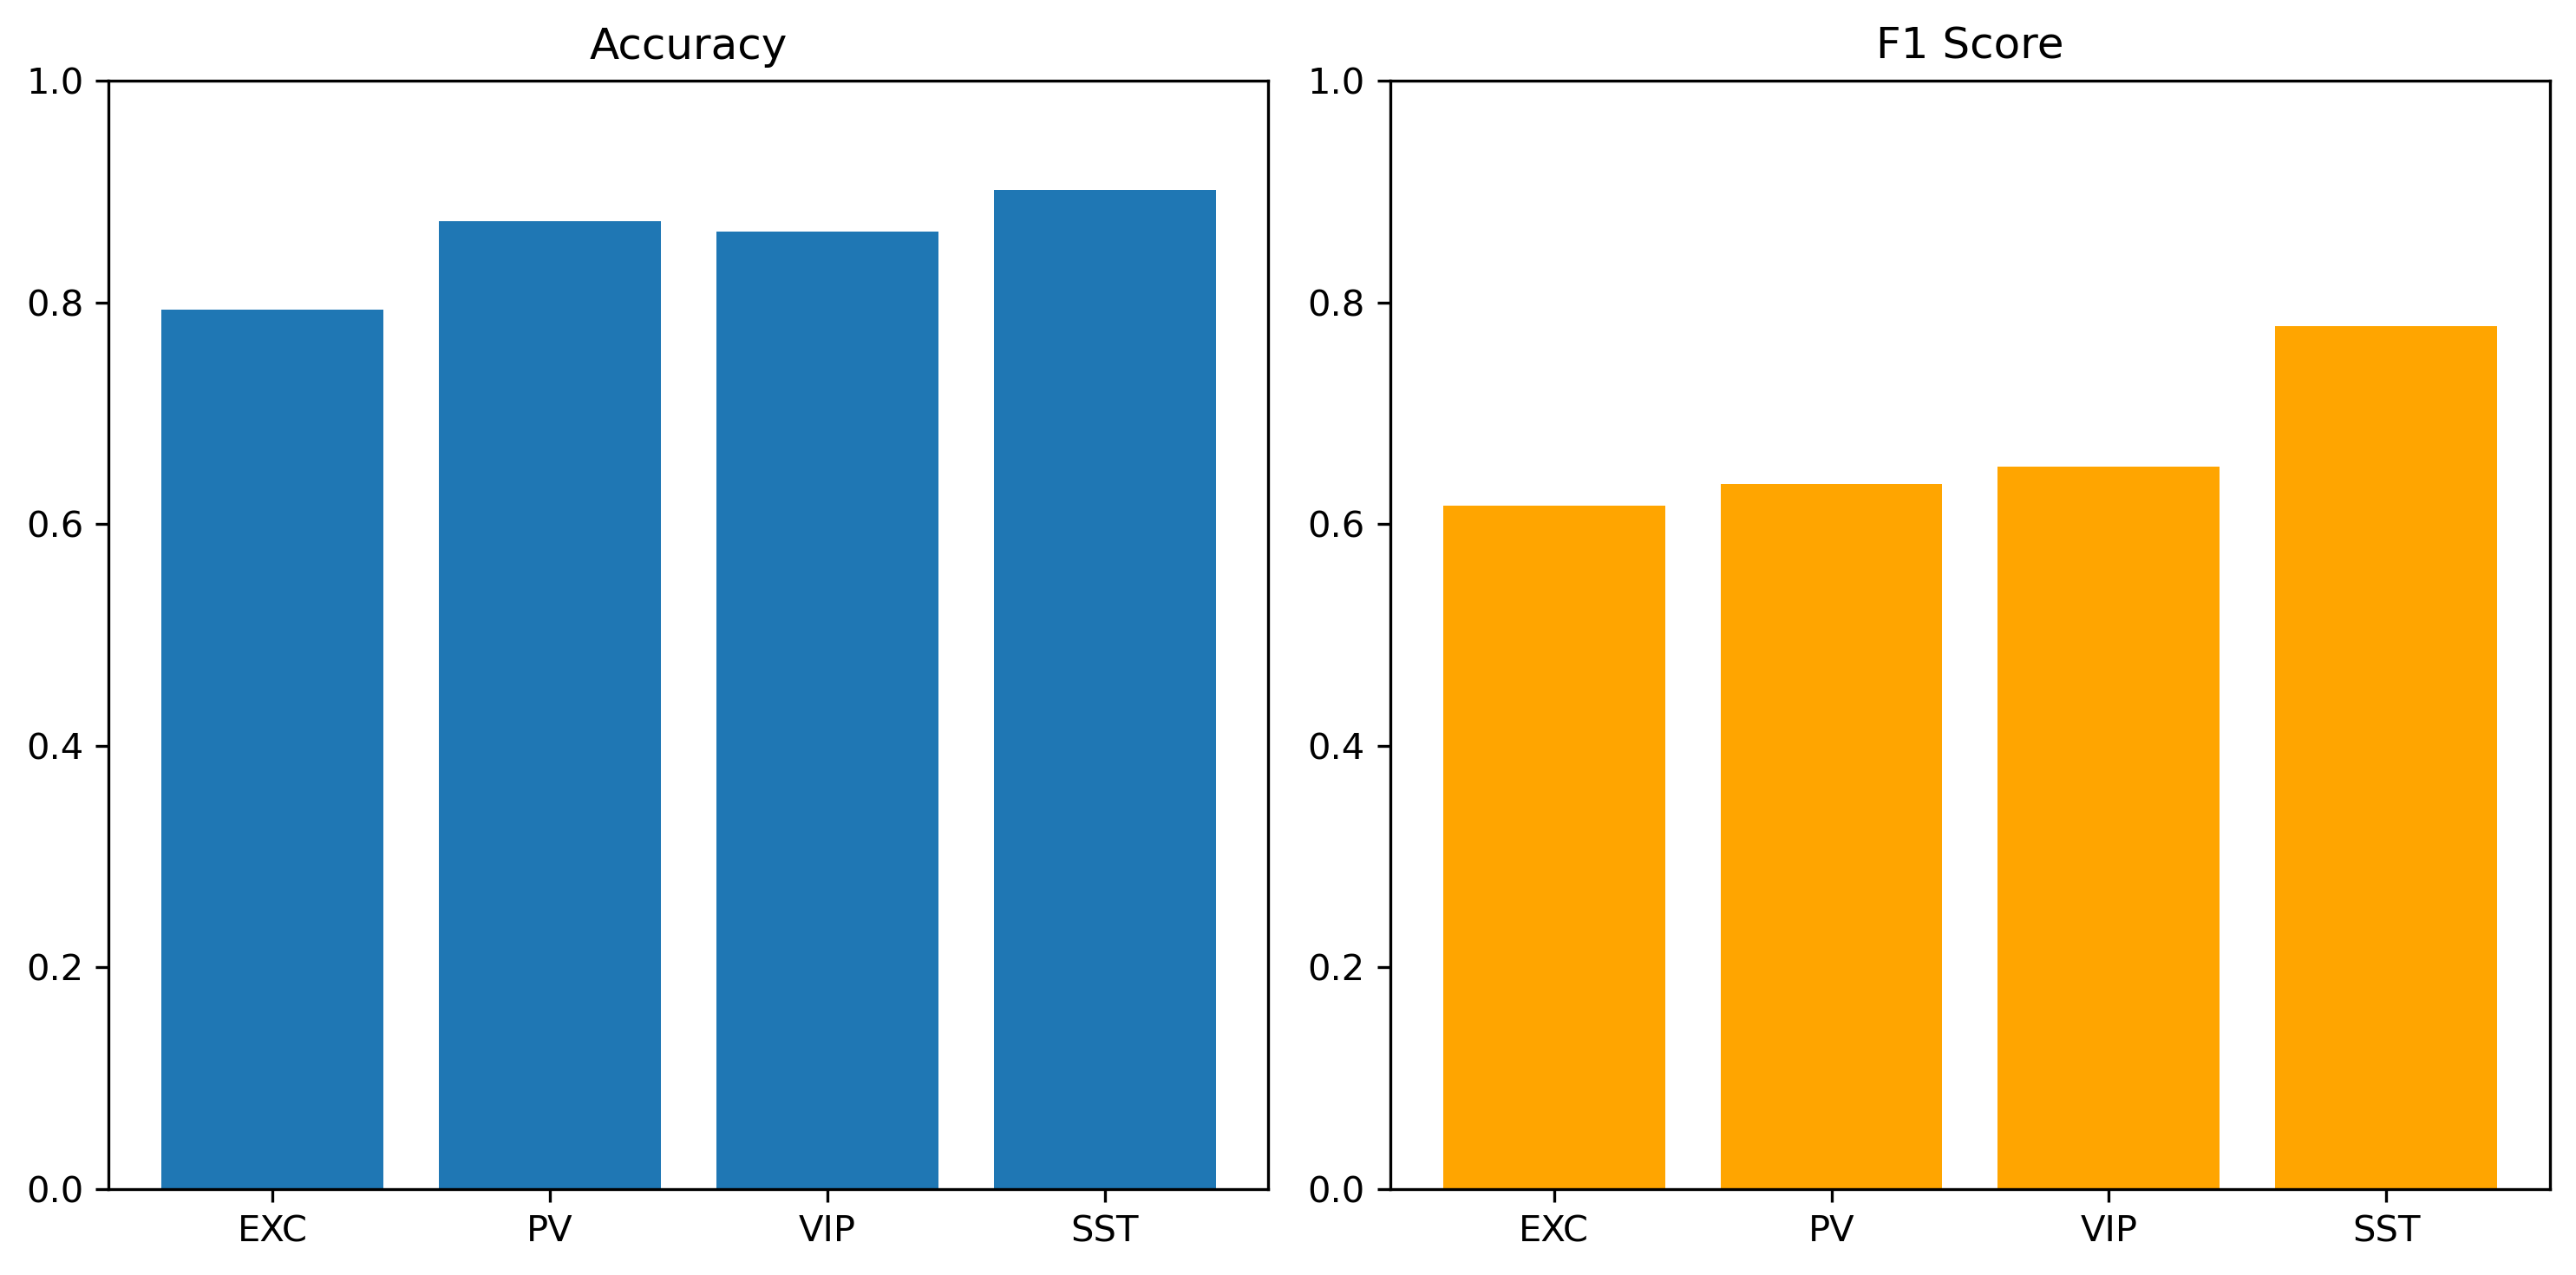

In [15]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
axs[0].bar(cell_type_labels, cell_type_accuracies)
axs[0].set_title("Accuracy")
axs[0].set_ylim(0, 1)
axs[1].bar(cell_type_labels, cell_type_f1, color='orange')
axs[1].set_title("F1 Score")
axs[1].set_ylim(0, 1)

print('Accuracies: ', cell_type_accuracies)
print('F1:         ', cell_type_f1)

plt.tight_layout()
plt.show()

# Correlation Matrices For Each Cell Type

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(55, 15), dpi=600)
data = data_preproc

for i, cell_type in enumerate(data_preproc["cell_type"].unique()):
    correlation_matrix = data_preproc[data_preproc["cell_type"] == cell_type].drop(columns=["cell_id", "cell_type", "label", "Cell_Anatomy"]).corr()
    correlation_matrix = np.abs(correlation_matrix)
    
    # Set custom threshold values for correlation categories
    high_corr_threshold = 0.75

    # Create masks for different correlation categories
    high_corr_mask = correlation_matrix >= high_corr_threshold

    cmap = 'coolwarm'
    # Create a categorical heatmap using Seaborn
    sns.heatmap(correlation_matrix, annot=True, cmap=cmap, linewidths=.5,
                          mask=~(high_corr_mask),
                          fmt=".2f",
                          ax=ax[i])  # Format annotation values as two decimal places
    ax[i].set_title(f'{cell_type_reverse_mapping[cell_type]}', fontsize=60)


plt.tight_layout()
plt.show()

# Removing Highly Correlated Features and Retraining the Model

In [5]:
result_dict = {
    'cell_type': [],
    'correlated_features': [],
    'kept_features': [],
    'accuracy':  [],
    'f1':  [],
}

# For each cell type
for cell_type in tqdm(data_preproc['cell_type'].unique()):
    correlation_threshold = 0.75

    labels = data_preproc['label']
    data_filtered = data_preproc[data_preproc["cell_type"] == cell_type].drop(columns=["cell_id", "cell_type", "label", "Cell_Anatomy"])

    corr_matrix = data_filtered.corr().abs()
    # Create a mask to ignore self-correlation (diagonal elements)
    mask = (corr_matrix.mask(np.tril(np.ones(corr_matrix.shape)).astype(bool)) >= correlation_threshold)
    # Identify groups of correlated features
    correlated_groups = [list(group) for group in nx.connected_components(nx.from_numpy_array(mask.values))]
    correlated_groups_names = [sorted(list(data_filtered.columns[group].to_numpy())) for group in correlated_groups if len(group) > 1]

    # Keep only one feature from each group and remove the rest
    features_to_keep = []
    for group in correlated_groups:
        if len(group) > 1:
            print(f'{cell_type_reverse_mapping[cell_type]}, Correlated Group: {sorted(data_filtered.columns[group].to_numpy())}, Only keep: {data_filtered.columns[group[0]]}')
        features_to_keep.append(group[0])

    print(f'{cell_type_reverse_mapping[cell_type]}, Total Features Left: {len(features_to_keep)}')
    X = data_filtered.iloc[:, features_to_keep].copy()
    X['label'] = labels
    result = model(X)
    print()

    result_dict['cell_type'].append(cell_type)
    result_dict['correlated_features'].append(correlated_groups_names)
    result_dict['kept_features'].append(sorted(list(data_filtered.columns[features_to_keep].to_numpy())))
    result_dict['accuracy'].append(result[0])
    result_dict['f1'].append(result[1])


correlation_df = pd.DataFrame(result_dict)
correlation_df

  0%|                                                                                                                           | 0/4 [00:00<?, ?it/s]

EXC, Correlated Group: ['vm_amplitude_post', 'vm_amplitude_pre', 'vm_mav_post', 'vm_mav_pre', 'vm_max_post', 'vm_max_pre', 'vm_rms_post', 'vm_rms_pre'], Only keep: vm_amplitude_pre
EXC, Correlated Group: ['vm_wl_post', 'vm_wl_pre'], Only keep: vm_wl_pre
EXC, Correlated Group: ['vm_ssc_post', 'vm_ssc_pre'], Only keep: vm_ssc_pre
EXC, Total Features Left: 10


 25%|████████████████████████████▌                                                                                     | 1/4 [11:44<35:12, 704.26s/it]


PV, Correlated Group: ['vm_amplitude_pre', 'vm_mav_pre', 'vm_max_pre', 'vm_rms_pre', 'vm_std_pre'], Only keep: vm_amplitude_pre
PV, Correlated Group: ['vm_amplitude_post', 'vm_mav_post', 'vm_max_post', 'vm_rms_post'], Only keep: vm_amplitude_post
PV, Correlated Group: ['vm_wl_post', 'vm_wl_pre'], Only keep: vm_wl_pre
PV, Total Features Left: 11


 50%|█████████████████████████████████████████████████████████                                                         | 2/4 [12:05<10:05, 302.50s/it]


VIP, Correlated Group: ['vm_amplitude_pre', 'vm_mav_pre', 'vm_max_pre', 'vm_rms_pre'], Only keep: vm_amplitude_pre
VIP, Correlated Group: ['vm_amplitude_post', 'vm_mav_post', 'vm_max_post', 'vm_rms_post'], Only keep: vm_amplitude_post
VIP, Correlated Group: ['vm_wl_post', 'vm_wl_pre'], Only keep: vm_wl_pre
VIP, Correlated Group: ['vm_ssc_post', 'vm_ssc_pre'], Only keep: vm_ssc_pre
VIP, Total Features Left: 11


 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 3/4 [12:11<02:47, 167.17s/it]


SST, Correlated Group: ['vm_amplitude_post', 'vm_amplitude_pre', 'vm_mav_post', 'vm_mav_pre', 'vm_max_post', 'vm_max_pre', 'vm_rms_post', 'vm_rms_pre'], Only keep: vm_amplitude_pre
SST, Correlated Group: ['vm_wl_post', 'vm_wl_pre'], Only keep: vm_wl_pre
SST, Total Features Left: 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [13:00<00:00, 195.02s/it]

cell_type                                correlated_features  \
0          0  [[vm_amplitude_post, vm_amplitude_pre, vm_mav_...   
1          1  [[vm_amplitude_pre, vm_mav_pre, vm_max_pre, vm...   
2          2  [[vm_amplitude_pre, vm_mav_pre, vm_max_pre, vm...   
3          3  [[vm_amplitude_post, vm_amplitude_pre, vm_mav_...   

                                       kept_features  accuracy        f1  
0  [Cell_Depth, ap_fr_post, ap_fr_pre, fft_high, ...  0.753005  0.466375  
1  [Cell_Depth, ap_fr_post, ap_fr_pre, fft_high, ...  0.865057  0.618525  
2  [Cell_Depth, ap_fr_post, ap_fr_pre, fft_high, ...  0.823670  0.495162  
3  [Cell_Depth, ap_fr_post, ap_fr_pre, fft_high, ...  0.884269  0.731988

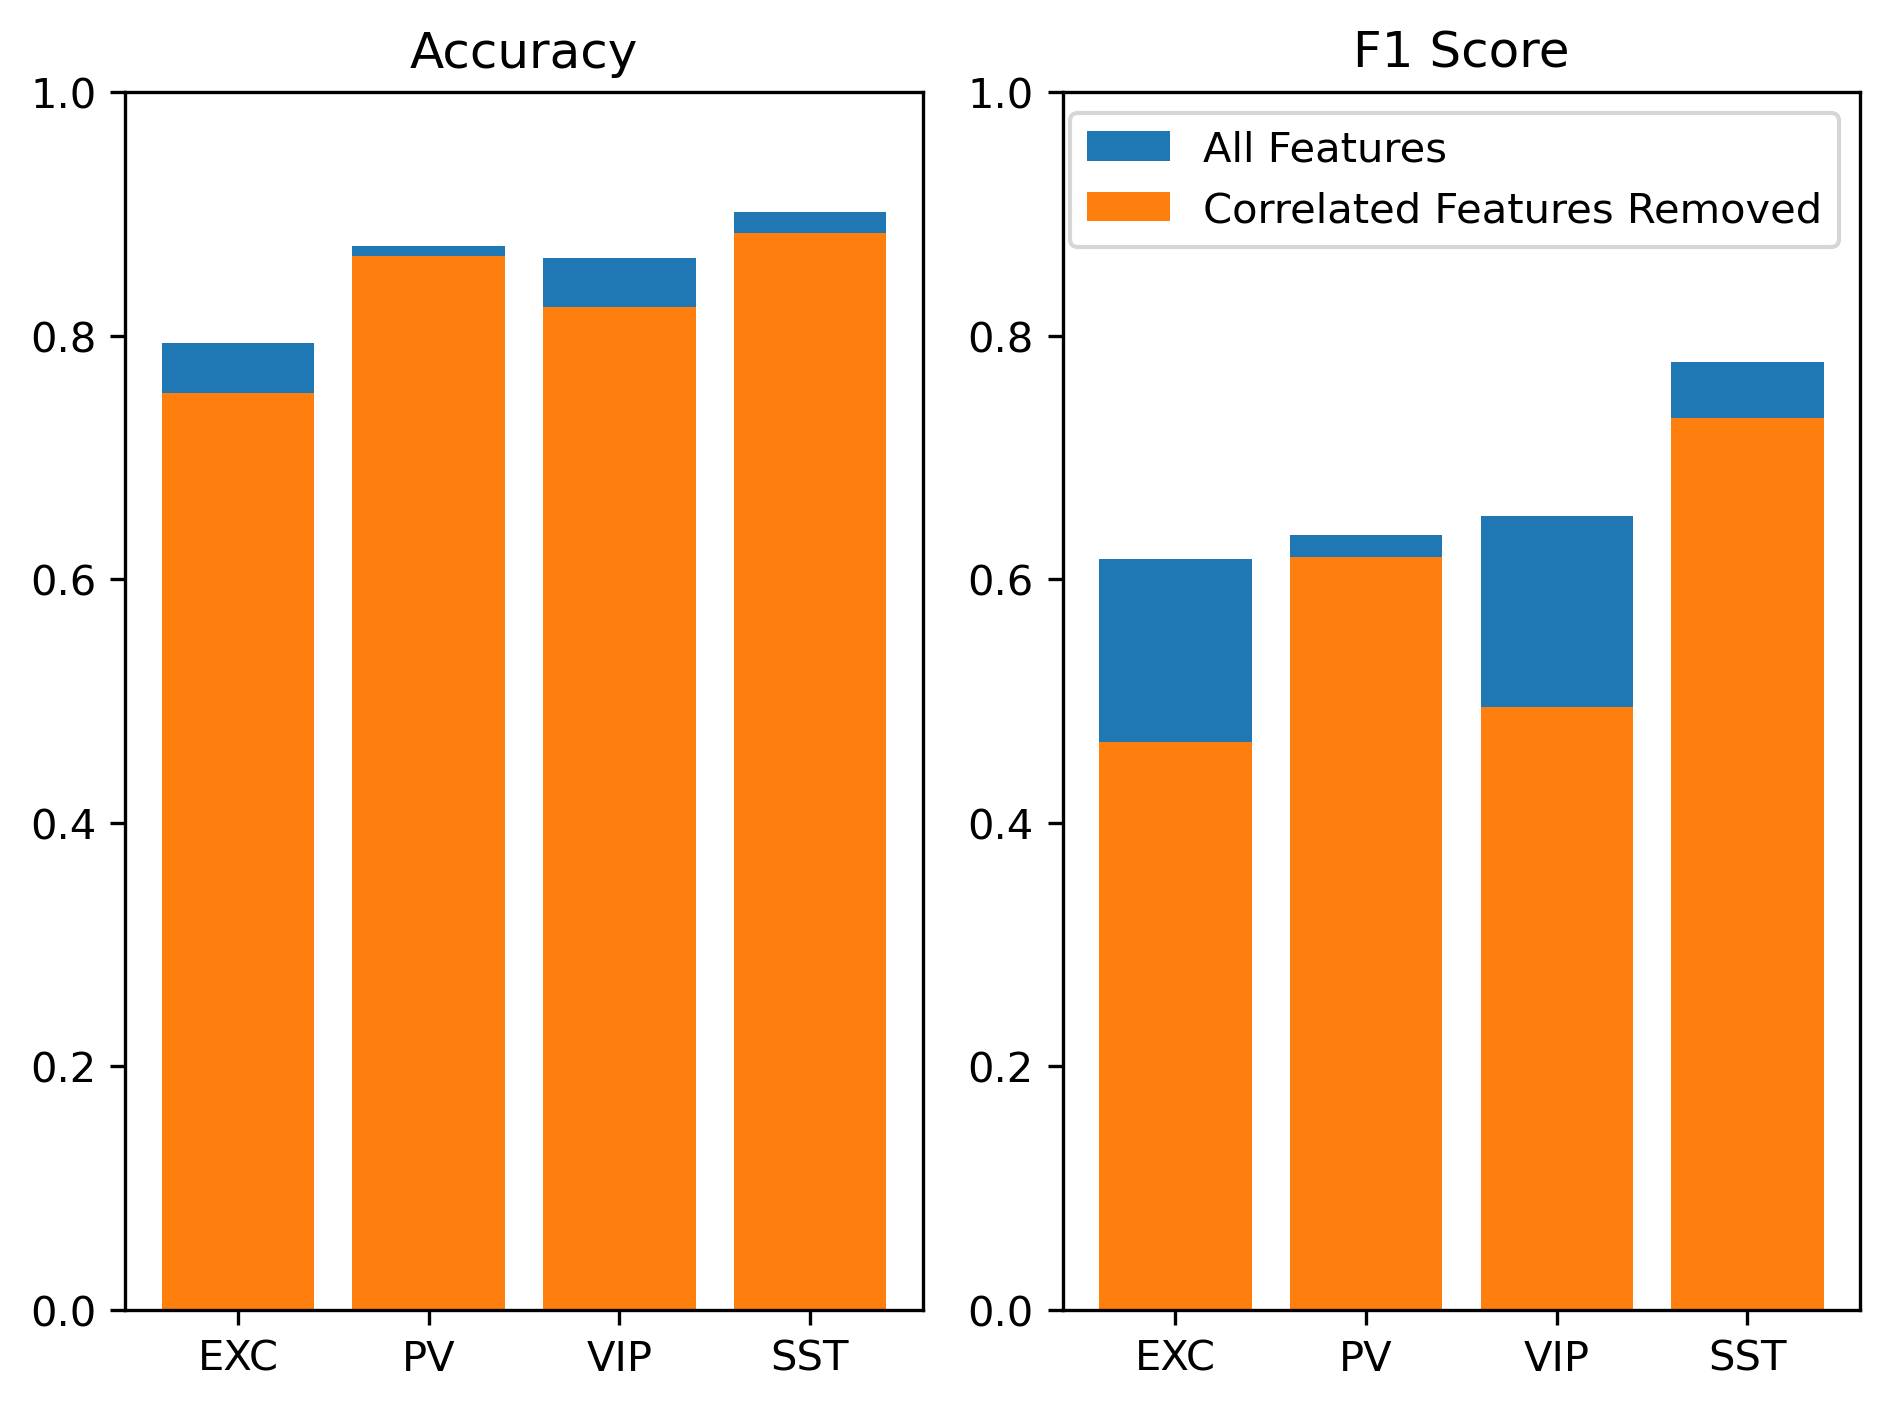

In [6]:
cell_type_accuracies = [0.7935427018679304, 0.8734221722161669, 0.8637952559300874, 0.9014845097121192]
cell_type_f1 = [0.6164775388898499, 0.6360491679796808, 0.6514655263435751, 0.7783493301246012]

fig, axs = plt.subplots(1, 2, dpi=300)
axs[0].bar(cell_type_labels, cell_type_accuracies, label='All Features')
axs[0].bar(cell_type_labels, correlation_df['accuracy'], label='Correlated Features Removed')
axs[0].set_title("Accuracy")
axs[0].set_ylim(0, 1)

axs[1].bar(cell_type_labels, cell_type_f1, label='All Features')
axs[1].bar(cell_type_labels, correlation_df['f1'], label='Correlated Features Removed')
axs[1].set_title("F1 Score")
axs[1].set_ylim(0, 1)


plt.tight_layout()
plt.legend()
plt.show()


# Premutation Feature Importance

In [22]:
np.random.seed(7)

results_dict = {
    'cell_type':  [],
    'accuracy':  [],
    'f1':  [],
    'top_features':  [],
    'feature_scores':  [],
    'accuracy_with_top_features': [],
    'f1_with_top_features': [],
}

for cell_type in tqdm(data_preproc['cell_type'].unique()):

    data_filtered = data_preproc[data_preproc['cell_type'] == cell_type].drop(columns=['cell_type', 'Cell_Anatomy', 'cell_id'])
    sub_features = data_filtered.drop('label', axis=1).copy()
    sub_labels = data_filtered['label'].copy()
    features_strings = sub_features.columns.values
    sub_features.reset_index(drop=True, inplace=True)
    sub_labels.reset_index(drop=True, inplace=True)

    X = sub_features[correlation_df['kept_features'].iloc[cell_type]]
    features_strings = X.columns.values
    y = sub_labels
    
    # Nested Crossvalidation
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
    ])
    param_grid = {
        'classifier__C': [0.1, 1, 10, 100, 1000],          # Regularization parameter
        'classifier__kernel': ['linear', 'rbf', 'sigmoid'],  # Kernel type
        'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 'auto'],    # Kernel coefficient
    }

    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=0)
    model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=-1, verbose=0)
    scoring_metrics = {
        'accuracy': 'accuracy',
        'f1': 'f1',
    }
    scores = cross_validate(model, X, y,
                            scoring=scoring_metrics,
                            cv=outer_cv, n_jobs=-1, return_train_score=True)
    accuracy = scores['test_accuracy'].mean()
    f1 = scores['test_f1'].mean()
    

    # Feature Importance
    k = 5
    model.fit(X, y)
    perm_importance = permutation_importance(model.best_estimator_, X, y, n_repeats=30, random_state=42, n_jobs=-1)
    indices = np.argsort(perm_importance.importances_mean)[::-1][:k]
    X_topK = X.iloc[:, indices]
    scores = cross_validate(model.best_estimator_, X_topK, y, cv=outer_cv, scoring=scoring_metrics, n_jobs=-1)
    accuracy_best = scores['test_accuracy'].mean()
    f1_best = scores['test_f1'].mean()

    results_dict['cell_type'].append(cell_type)
    results_dict['accuracy'].append(accuracy)
    results_dict['f1'].append(f1)
    results_dict['top_features'].append(np.array(features_strings)[indices])
    results_dict['feature_scores'].append(perm_importance.importances_mean)
    results_dict['accuracy_with_top_features'].append(accuracy_best)
    results_dict['f1_with_top_features'].append(f1_best)

df_cell_type_pfi = pd.DataFrame(results_dict)
df_cell_type_pfi.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [18:41<00:00, 280.41s/it]


cell_type  accuracy        f1  \
0          0  0.753005  0.466375   
1          1  0.865057  0.618525   
2          2  0.823670  0.495162   
3          3  0.884269  0.731988   

                                        top_features  \
0  [fft_high, fft_low, vm_wl_pre, vm_ssc_pre, Cel...   
1  [ap_fr_post, vm_ssc_post, vm_ssc_pre, vm_ampli...   
2  [ap_fr_post, vm_amplitude_post, fft_low, fft_h...   
3  [vm_ssc_post, vm_ssc_pre, vm_amplitude_pre, vm...   

                                      feature_scores  \
0  [0.049478987747623986, 0.02600480934386813, 0....   
1  [0.0524168762224085, 0.12377759150600726, 0.03...   
2  [0.05066964285714284, 0.10662202380952378, 0.0...   
3  [0.020771560656783036, 0.03499123226526383, 0....   

   accuracy_with_top_features  f1_with_top_features  
0                    0.751630              0.383452  
1                    0.871752              0.600136  
2                    0.805793              0.436337  
3                    0.877570              0.713804

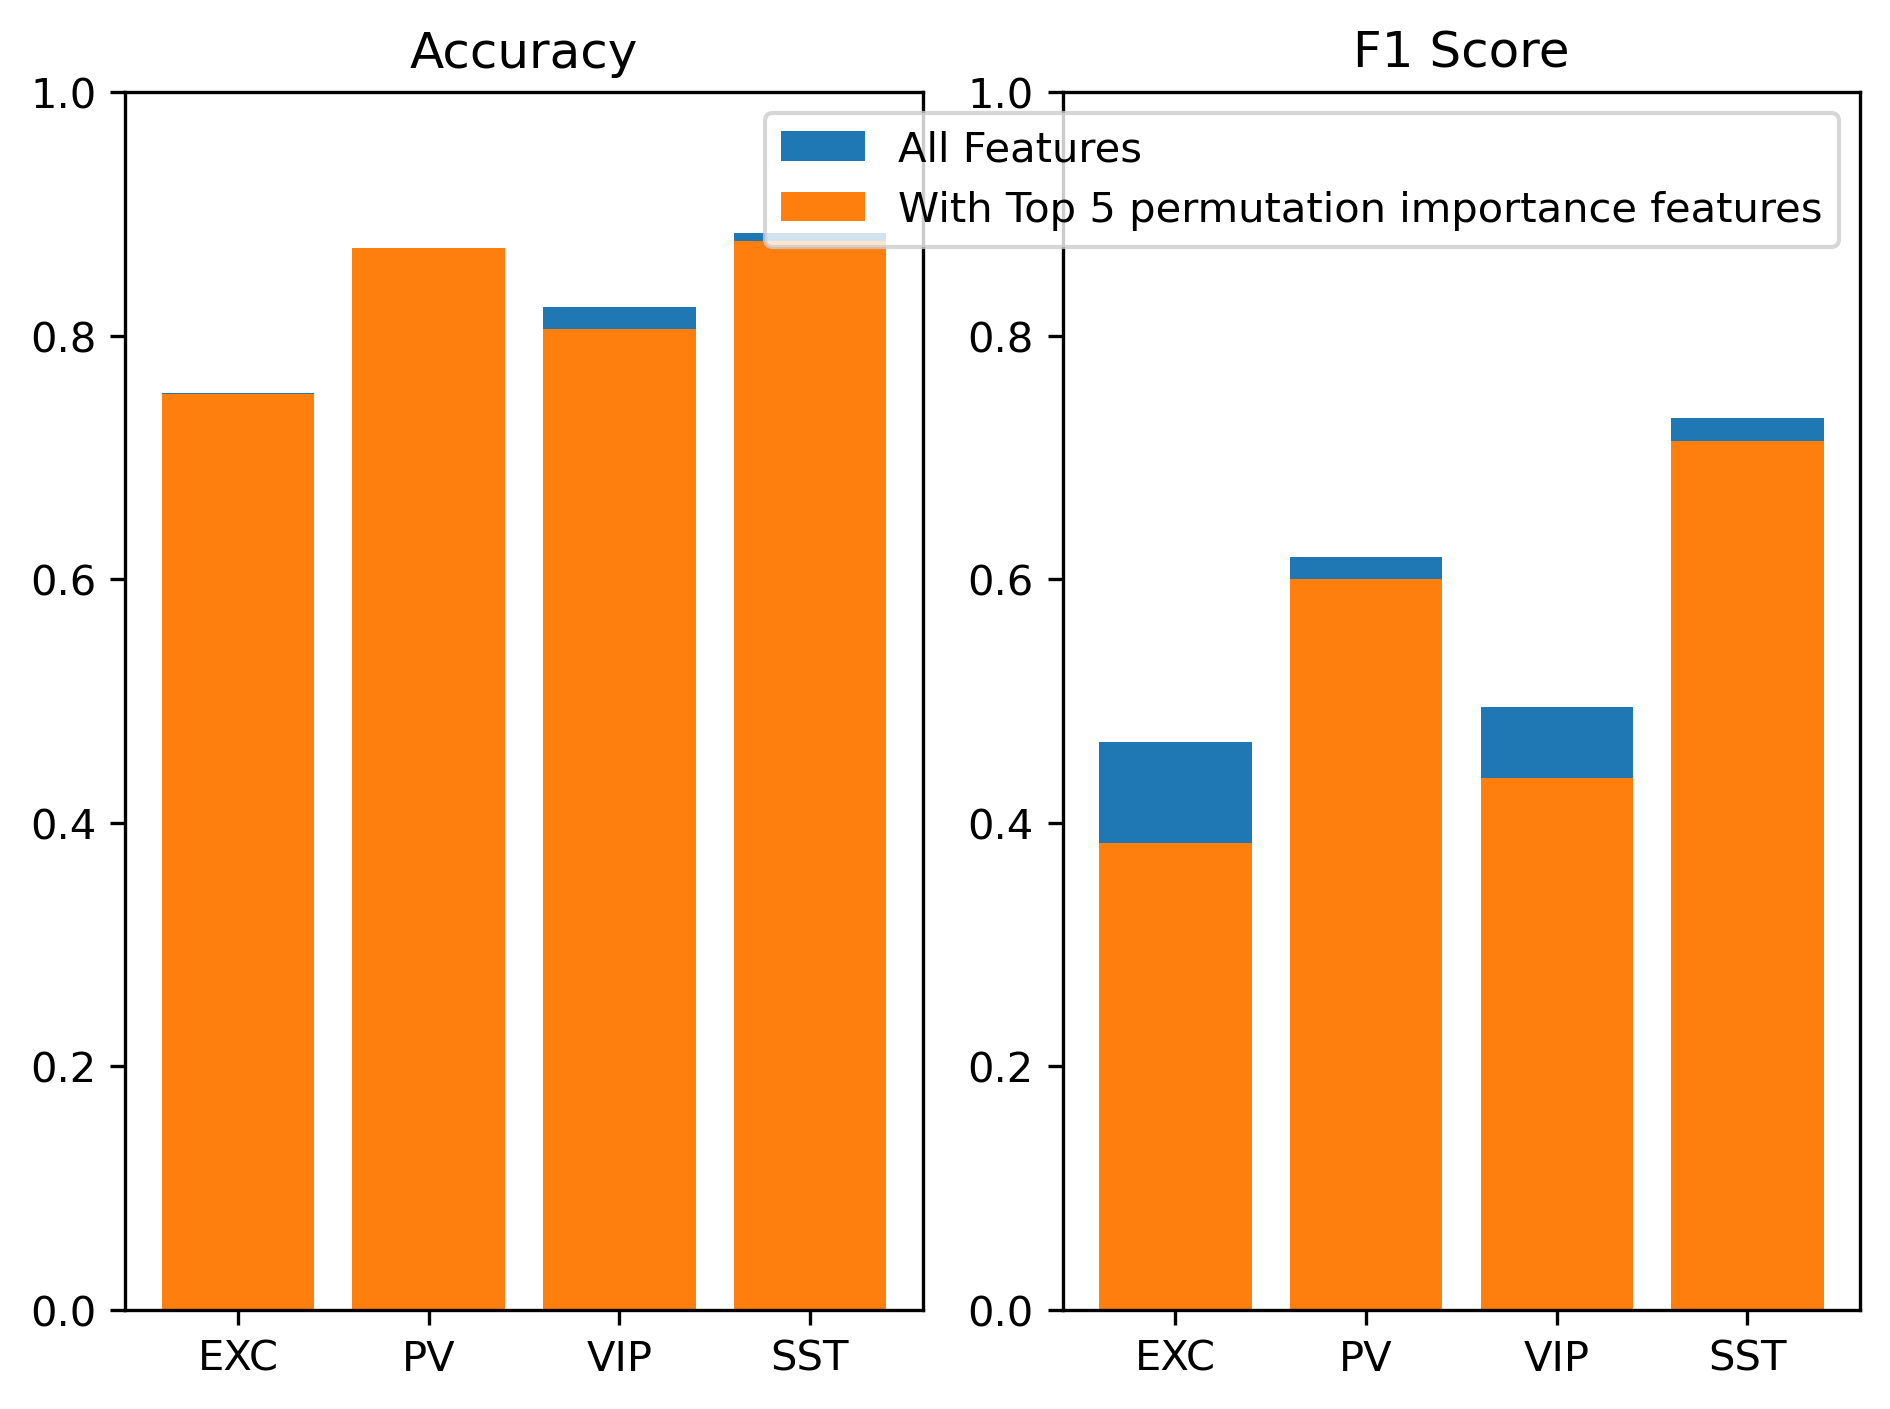

In [23]:
cell_type_labels = ['EXC', 'PV', 'VIP', 'SST']

fig, axs = plt.subplots(1, 2, dpi=300)
axs[0].bar(cell_type_labels, df_cell_type_pfi['accuracy'], label='All Features')
axs[0].bar(cell_type_labels, df_cell_type_pfi['accuracy_with_top_features'], label='With Top 5 permutation importance features')
axs[0].set_title("Accuracy")
axs[0].set_ylim(0, 1)

axs[1].bar(cell_type_labels, df_cell_type_pfi['f1'], label='All Features')
axs[1].bar(cell_type_labels, df_cell_type_pfi['f1_with_top_features'], label='With Top 5 permutation importance features')
axs[1].set_title("F1 Score")
axs[1].set_ylim(0, 1)


plt.tight_layout()
plt.legend()
plt.show()

In [25]:
important_features_df_ranking = pd.DataFrame(list(df_cell_type_pfi['top_features']))
important_features_df_ranking.insert(0, 'cell_type', cell_type_labels)
important_features_df_ranking

cell_type            0                  1                 2  \
0       EXC     fft_high            fft_low         vm_wl_pre   
1        PV   ap_fr_post        vm_ssc_post        vm_ssc_pre   
2       VIP   ap_fr_post  vm_amplitude_post           fft_low   
3       SST  vm_ssc_post         vm_ssc_pre  vm_amplitude_pre   

                   3                 4  
0         vm_ssc_pre        Cell_Depth  
1  vm_amplitude_post  vm_amplitude_pre  
2           fft_high  vm_amplitude_pre  
3          vm_wl_pre        ap_fr_post

Important Features: ['ap_fr_post', 'vm_ssc_pre', 'vm_ssc_post', 'fft_high', 'fft_low', 'vm_amplitude_post', 'vm_wl_pre', 'vm_amplitude_pre', 'Cell_Depth']


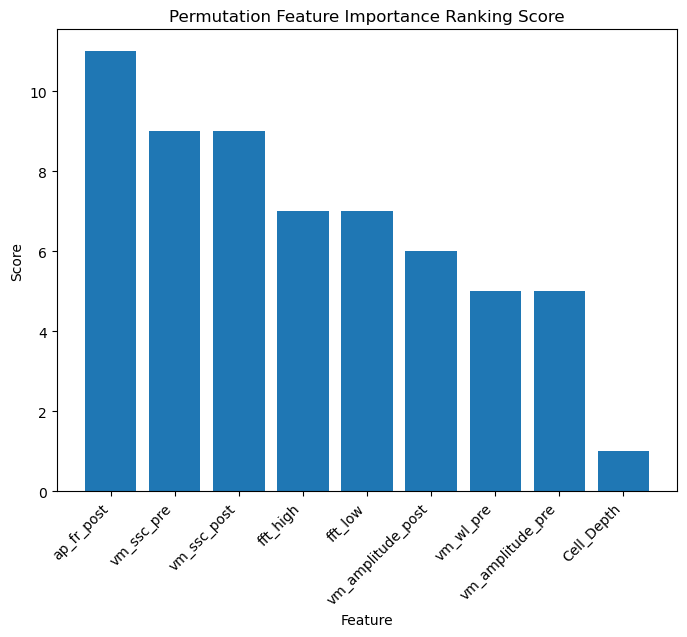

In [26]:
k = 5

top_feature_ranking = {}
for _, row in important_features_df_ranking.iterrows():
    for i in range(1, k+1):
        top_feature_ranking[row.iloc[i]]  = top_feature_ranking.get(row.iloc[i], 0) + (k-i+1)

top_feature_ranking =  dict(sorted(top_feature_ranking.items(), key=lambda item: item[1],  reverse=True))
print("Important Features:", list(top_feature_ranking.keys()))
plt.figure(figsize=(8, 6))
plt.bar(top_feature_ranking.keys(), top_feature_ranking.values())
plt.title(f'Permutation Feature Importance Ranking Score')
plt.xlabel("Feature")
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.show()

# Draw the pair plots for the five most important features againts the label

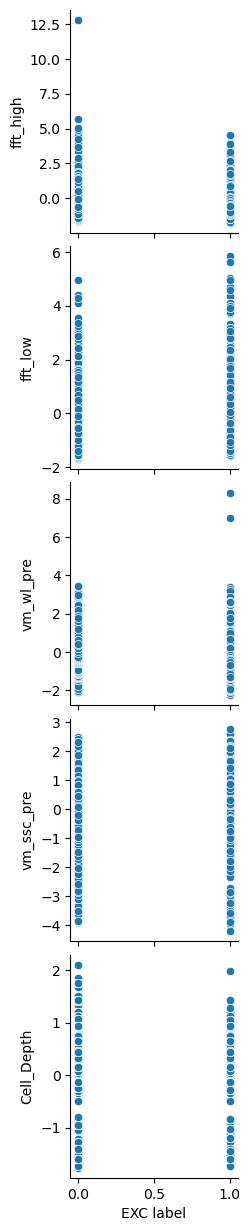

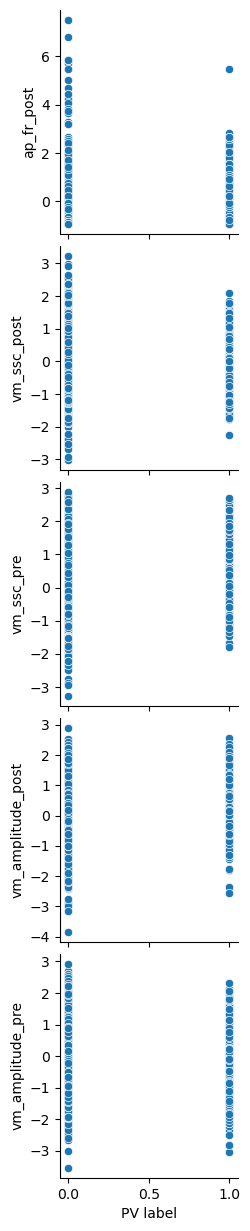

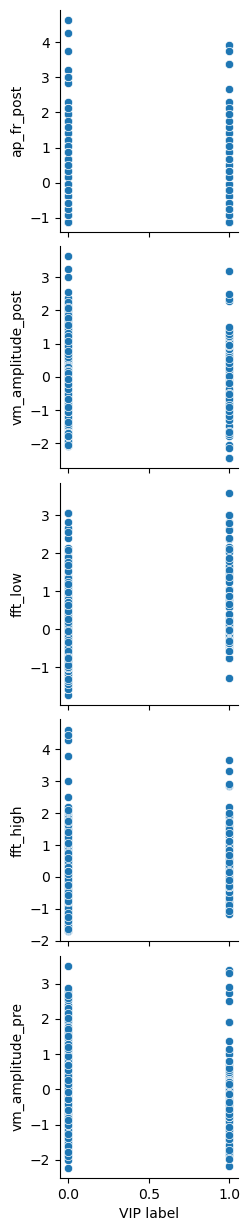

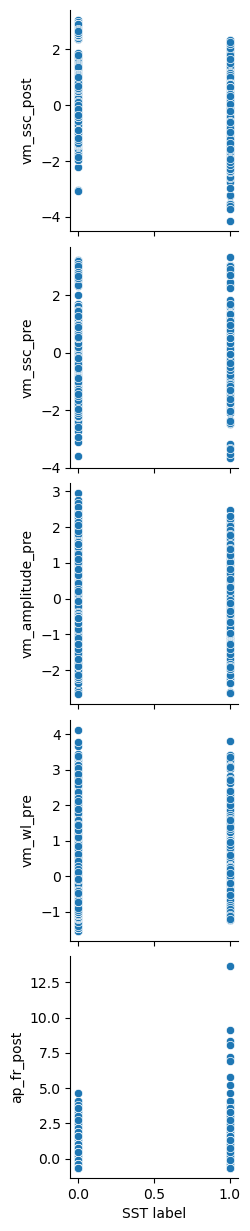

In [27]:
for cell_type in data_preproc['cell_type'].unique():
    data_filtered = data_preproc[data_preproc['cell_type'] == cell_type].drop(columns=['cell_type', 'Cell_Anatomy', 'cell_id'])

    sub_features = data_filtered.drop('label', axis=1).copy()
    sub_labels = data_filtered['label'].copy()
    features_strings = sub_features.columns.values
    sub_features.reset_index(drop=True, inplace=True)
    sub_labels.reset_index(drop=True, inplace=True)

    top_features = df_cell_type_pfi[df_cell_type_pfi['cell_type'] == cell_type]['top_features'].iloc[0]
    column_indices = [sub_features.columns.get_loc(col) for col in top_features]


    scaler = StandardScaler()
    X_z = scaler.fit_transform(sub_features.iloc[:, column_indices])
    X_z = pd.DataFrame(X_z, columns=top_features)
    X_z['label'] = sub_labels
    sns.pairplot(data=X_z, x_vars=['label'], y_vars=top_features)
    plt.xlabel(f'{cell_type_reverse_mapping[cell_type]} label')

# Recursive Feature Extraction

In [25]:
# A Posteriori
np.random.seed(7)
from sklearn.inspection import permutation_importance
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.feature_selection import RFE

results_dict = {
    'cell_type':  [],
    'accuracy':  [],
    'f1':  [],
    'top_features':  [],
    'accuracy_with_top_features': [],
    'f1_with_top_features': [],
}

for cell_type in tqdm(data_preproc['cell_type'].unique()):
    data_filtered = data_preproc[data_preproc['cell_type'] == cell_type].drop(columns=['cell_type', 'Cell_Anatomy', 'cell_id'])
    sub_features = data_filtered.drop('label', axis=1).copy()
    sub_labels = data_filtered['label'].copy()
    features_strings = sub_features.columns.values
    sub_features.reset_index(drop=True, inplace=True)
    sub_labels.reset_index(drop=True, inplace=True)

    X = sub_features
    y = sub_labels
    
    # Nested Crossvalidation
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
    ])
    param_grid = {
        'classifier__C': [0.1, 1, 10, 100, 1000],          # Regularization parameter
        'classifier__kernel': ['linear', 'rbf', 'sigmoid'],  # Kernel type
        'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 'auto'],    # Kernel coefficient
    }

    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=0)
    model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=-1, verbose=0)
    scoring_metrics = {
        'accuracy': 'accuracy',
        'f1': 'f1',
    }
    scores = cross_validate(model, X, y,
                            scoring=scoring_metrics,
                            cv=outer_cv, n_jobs=-1, return_train_score=True)
    accuracy = scores['test_accuracy'].mean()
    f1 = scores['test_f1'].mean()
    

    # Feature Importance
    k = 5
    model.fit(X, y)
    scaler = StandardScaler()
    X_z = scaler.fit_transform(X)
    top_features = {}
    for inner_k in range(1, k+1):
        model_rfe = SVC(kernel='linear', random_state=42)
        rfe = RFE(model_rfe, n_features_to_select=inner_k, step=1)
        rfe.fit(X_z, y)
        indices = np.where(rfe.support_)[0]
        for i in indices:
            top_features[features_strings[i]] = None

    X_topK = X.iloc[:, indices]
    scores = cross_validate(model.best_estimator_, X_topK, y, cv=outer_cv, scoring=scoring_metrics, n_jobs=-1)
    accuracy_best = scores['test_accuracy'].mean()
    f1_best = scores['test_f1'].mean()

    results_dict['cell_type'].append(cell_type)
    results_dict['accuracy'].append(accuracy)
    results_dict['f1'].append(f1)
    results_dict['top_features'].append(list(top_features.keys()))
    results_dict['accuracy_with_top_features'].append(accuracy_best)
    results_dict['f1_with_top_features'].append(f1_best)

df_cell_type_rfe = pd.DataFrame(results_dict)
df_cell_type_rfe.head()

  0%|                                                                                                                           | 0/4 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [08:59<00:00, 134.86s/it]


cell_type  accuracy        f1  \
0          0  0.793543  0.616478   
1          1  0.873422  0.636049   
2          2  0.863795  0.651466   
3          3  0.901485  0.778349   

                                        top_features  \
0  [vm_ssc_post, vm_ssc_pre, vm_wl_pre, vm_wl_pos...   
1  [ap_fr_post, ap_fr_pre, vm_wl_post, vm_wl_pre,...   
2  [vm_wl_post, vm_ssc_post, vm_rms_post, Cell_De...   
3  [vm_wl_post, vm_wl_pre, vm_ssc_post, vm_ssc_pr...   

   accuracy_with_top_features  f1_with_top_features  
0                    0.764683              0.462412  
1                    0.864196              0.582101  
2                    0.850462              0.574919  
3                    0.876133              0.703990

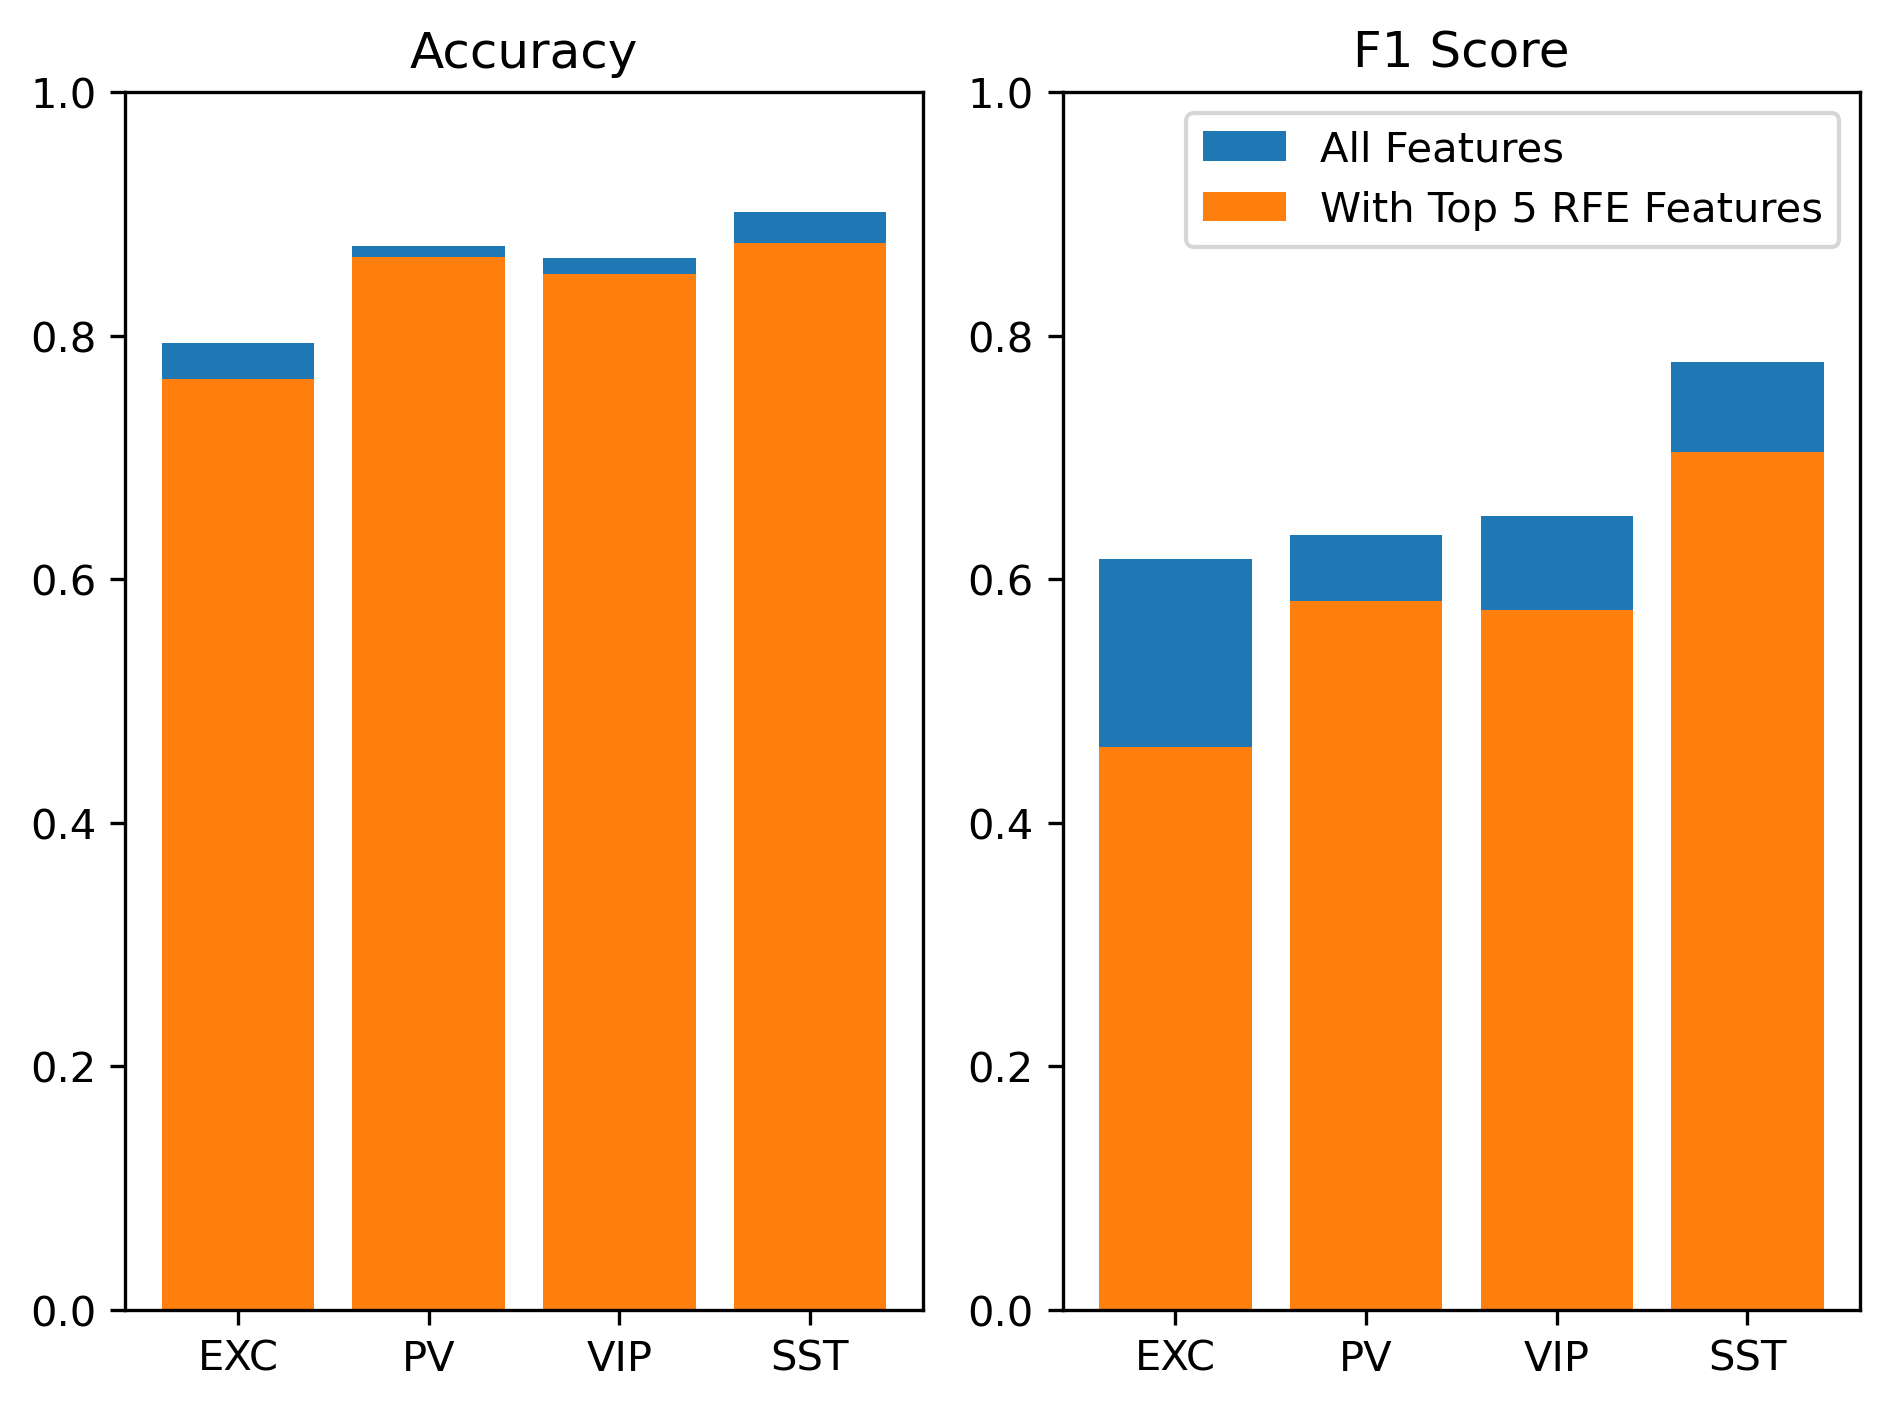

In [30]:
cell_type_labels = ['EXC', 'PV', 'VIP', 'SST']

fig, axs = plt.subplots(1, 2, dpi=300)
axs[0].bar(cell_type_labels, df_cell_type_rfe['accuracy'], label='All Features')
axs[0].bar(cell_type_labels, df_cell_type_rfe['accuracy_with_top_features'], label='With Top 5 RFE Features')
axs[0].set_title("Accuracy")
axs[0].set_ylim(0, 1)

axs[1].bar(cell_type_labels, df_cell_type_rfe['f1'], label='All Features')
axs[1].bar(cell_type_labels, df_cell_type_rfe['f1_with_top_features'], label='With Top 5 RFE Features')
axs[1].set_title("F1 Score")
axs[1].set_ylim(0, 1)


plt.tight_layout()
plt.legend()
plt.show()

# Draw the pair plots for the five most important features againts the label

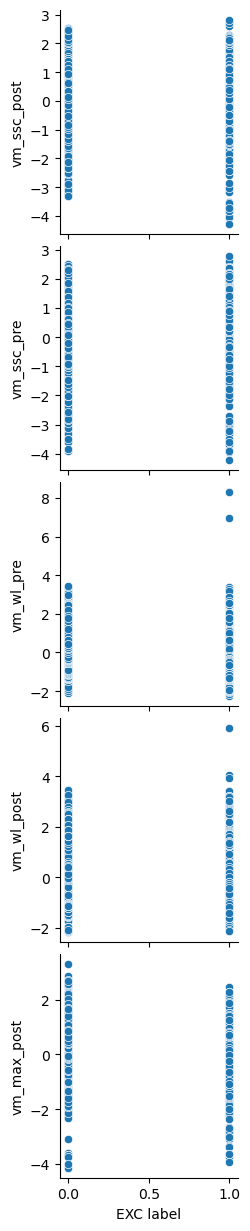

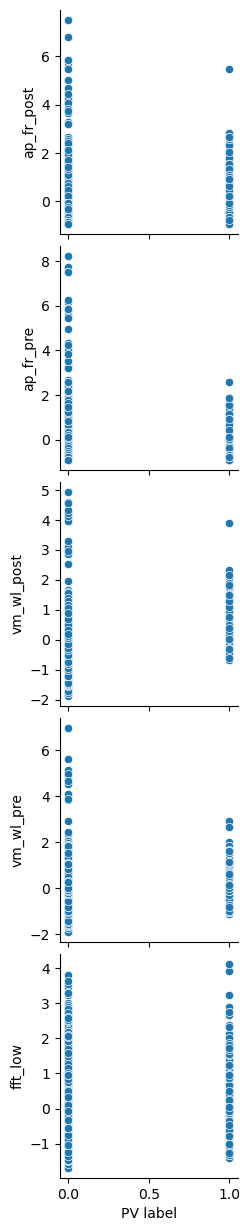

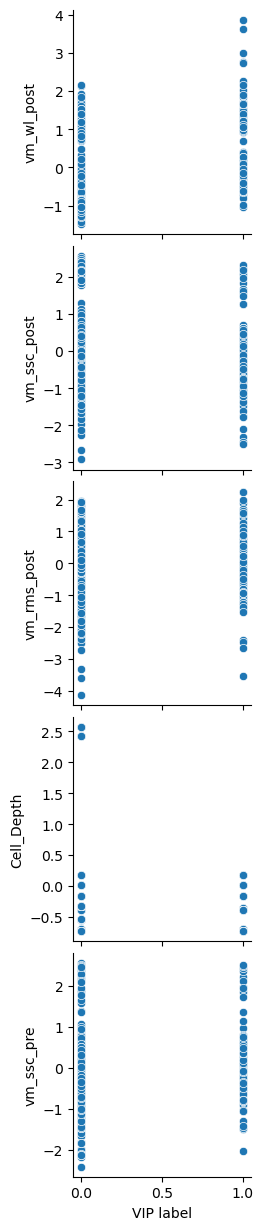

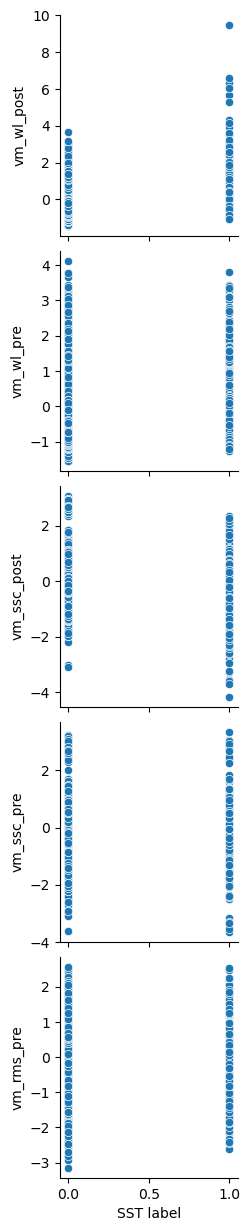

In [27]:
for cell_type in data_preproc['cell_type'].unique():
    data_filtered = data_preproc[data_preproc['cell_type'] == cell_type].drop(columns=['cell_type', 'Cell_Anatomy', 'cell_id'])

    sub_features = data_filtered.drop('label', axis=1).copy()
    sub_labels = data_filtered['label'].copy()
    features_strings = sub_features.columns.values
    sub_features.reset_index(drop=True, inplace=True)
    sub_labels.reset_index(drop=True, inplace=True)

    top_features = df_cell_type_rfe[df_cell_type_rfe['cell_type'] == cell_type]['top_features'].iloc[0]
    column_indices = [sub_features.columns.get_loc(col) for col in top_features]


    scaler = StandardScaler()
    X_z = scaler.fit_transform(sub_features.iloc[:, column_indices])
    X_z = pd.DataFrame(X_z, columns=top_features)
    X_z['label'] = sub_labels
    sns.pairplot(data=X_z, x_vars=['label'], y_vars=top_features)
    plt.xlabel(f'{cell_type_reverse_mapping[cell_type]} label')

In [28]:
important_features_df_ranking = pd.DataFrame(list(df_cell_type_rfe['top_features']))
important_features_df_ranking.insert(0, 'cell_type', cell_type_labels)
important_features_df_ranking

cell_type            0            1            2           3            4
0       EXC  vm_ssc_post   vm_ssc_pre    vm_wl_pre  vm_wl_post  vm_max_post
1        PV   ap_fr_post    ap_fr_pre   vm_wl_post   vm_wl_pre      fft_low
2       VIP   vm_wl_post  vm_ssc_post  vm_rms_post  Cell_Depth   vm_ssc_pre
3       SST   vm_wl_post    vm_wl_pre  vm_ssc_post  vm_ssc_pre   vm_rms_pre

Important Features: ['vm_wl_post', 'vm_ssc_post', 'vm_wl_pre', 'vm_ssc_pre', 'ap_fr_post', 'ap_fr_pre', 'vm_rms_post', 'Cell_Depth', 'vm_max_post', 'fft_low', 'vm_rms_pre']


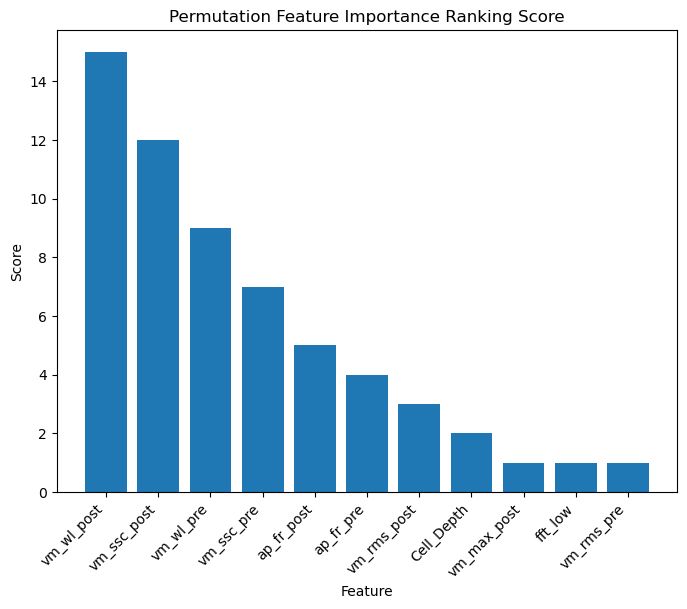

In [29]:
k = 5

top_feature_ranking = {}
for _, row in important_features_df_ranking.iterrows():
    for i in range(1, k+1):
        top_feature_ranking[row.iloc[i]]  = top_feature_ranking.get(row.iloc[i], 0) + (k-i+1)

top_feature_ranking =  dict(sorted(top_feature_ranking.items(), key=lambda item: item[1],  reverse=True))
print("Important Features:", list(top_feature_ranking.keys()))
plt.figure(figsize=(8, 6))
plt.bar(top_feature_ranking.keys(), top_feature_ranking.values())
plt.title(f'Permutation Feature Importance Ranking Score')
plt.xlabel("Feature")
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.show()

# Single Cell Classification

In [2]:
data_preproc = pd.read_pickle("proc_data.pkl")
data_preproc.head()
cell_type_mapping = {'EXC': 0, 'PV': 1, 'VIP': 2, 'SST': 3}
cell_type_labels = ['EXC', 'PV', 'VIP', 'SST']
cell_type_reverse_mapping = {0: 'EXC', 1: 'PV', 2: 'VIP', 3 : 'SST'}
cell_anatomy_mapping = {'L2/3': 0, 'L4': 1, 'L5': 2, 'nan': 3}

data_preproc = data_preproc.replace({'cell_type' : cell_type_mapping })
data_preproc.head()

cell_id  cell_type  vm_amplitude_pre  vm_amplitude_post  ap_fr_pre  \
0  JP902_1          0        -53.711890         -53.938270     0.0000   
1  JP902_1          0        -51.899546         -55.655256    12.0024   
2  JP902_1          0        -50.540924         -49.494906     0.0000   
3  JP902_1          0        -54.984081         -53.052701     0.0000   
4  JP902_1          0        -54.727469         -51.852798     0.0000   

   ap_fr_post   fft_low  fft_high  vm_mav_pre  vm_mav_post  ...  vm_std_post  \
0      4.0008  0.000638  0.000092    0.053712     0.053938  ...     0.003262   
1      0.0000  0.000447  0.000108    0.051900     0.055655  ...     0.002812   
2      8.0016  0.000901  0.000133    0.050541     0.049495  ...     0.003942   
3      0.0000  0.000537  0.000097    0.054984     0.053053  ...     0.003112   
4      4.0008  0.000744  0.000131    0.054727     0.051853  ...     0.002738   

   vm_rms_pre  vm_rms_post  vm_wl_pre  vm_wl_post  vm_ssc_pre  vm_ssc_post  \
0    0.231758     0.232246   0.151866    0.165975      2902.0       2653.0   
1    0.227815     0.235914   0.176212    0.156675      2472.0       2774.0   
2    0.224813     0.222475   0.157647    0.160081      2698.0       2485.0   
3    0.234487     0.230332   0.151756    0.157587      2744.0       2776.0   
4    0.233939     0.227712   0.154894    0.154166      2735.0       2670.0   

   label  Cell_Anatomy  Cell_Depth  
0    0.0          L2/3       348.0  
1    0.0          L2/3       348.0  
2    0.0          L2/3       348.0  
3    0.0          L2/3       348.0  
4    0.0          L2/3       348.0  

[5 rows x 23 columns]

# Select the cells that have more than the specified amount of windows

In [3]:
data_preproc = data_preproc.sort_values(by='Cell_Anatomy')
data_preproc.head()

at_df = data_preproc[data_preproc["label"] == 1]
at_df_cellid = at_df.groupby('cell_id').size().reset_index(name='count')
at_count_threshold = 15
at_df_cellid = at_df_cellid[at_df_cellid['count'] > at_count_threshold]

fw_df = data_preproc[data_preproc["label"] == 0]
fw_df_cellid = fw_df.groupby('cell_id').size().reset_index(name='count')
fw_count_threshold = 15
fw_df_cellid = fw_df_cellid[fw_df_cellid['count'] > fw_count_threshold]

# all the cells that have enough active touches based on at_count_threshold
classifiable_cellids_at = at_df_cellid['cell_id'].values
classifiable_cellids_fw = fw_df_cellid['cell_id'].values

classifiable_cellids = set(classifiable_cellids_at) & set(classifiable_cellids_fw)

classifiable_cellids

{'SC908_1',
 'SC918_1',
 'SC923_1',
 'SC925_1',
 'TK353_1',
 'TK355_1',
 'TK358_2',
 'TK373_1',
 'TK376_1',
 'TK383_1',
 'TK414_2',
 'TK415_2',
 'TK416_1',
 'TK416_2',
 'TK457_1',
 'TK462_3',
 'TK468_1',
 'TK470_2',
 'TK471_1',
 'TK480_3',
 'TK489_1',
 'TK490_2',
 'TK496_1',
 'TK511_2',
 'TK512_1'}

# Training a model on single cell and performing RFE

In [ ]:
np.random.seed(7)

results_dict = {
    'cell_id':  [],
    'accuracy':  [],
    'f1':  [],
    'top_features':  [],
    'accuracy_with_top_features': [],
    'f1_with_top_features': [],
}
x_bar_plot = []

for cid in tqdm(classifiable_cellids):
    x_bar_plot.append(cid)
    data_filtered = data_preproc[data_preproc['cell_id'] == cid].drop(columns=['cell_type', 'Cell_Anatomy', 'cell_id'])
    sub_features = data_filtered.drop('label', axis=1).copy()
    sub_labels = data_filtered['label'].copy()
    features_strings = sub_features.columns.values
    sub_features.reset_index(drop=True, inplace=True)
    sub_labels.reset_index(drop=True, inplace=True)

    X = sub_features
    y = sub_labels
    
    # Nested Crossvalidation
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
    ])
    param_grid = {
        'classifier__C': [0.1, 1, 10, 100, 1000],          # Regularization parameter
        'classifier__kernel': ['linear', 'rbf', 'sigmoid'],  # Kernel type
        'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 'auto'],    # Kernel coefficient
    }
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=-1)
    scoring_metrics = {
        'accuracy': 'accuracy',
        'f1': 'f1',
    }
    scores = cross_validate(model, X, y,
                            scoring=scoring_metrics,
                            cv=outer_cv, n_jobs=-1, return_train_score=True)
    accuracy = scores['test_accuracy'].mean()
    f1 = scores['test_f1'].mean()
    

    # Feature Importance
    k = 5
    model.fit(X, y)
    scaler = StandardScaler()
    X_z = scaler.fit_transform(X)
    top_features = {}
    for inner_k in range(1, k+1):
        model_rfe = SVC(kernel='linear', random_state=42)
        rfe = RFE(model_rfe, n_features_to_select=inner_k, step=1)
        rfe.fit(X_z, y)
        indices = np.where(rfe.support_)[0]
        for i in indices:
            top_features[features_strings[i]] = None

    X_topK = X.iloc[:, indices]
    scores = cross_validate(model.best_estimator_, X_topK, y, cv=outer_cv, scoring=scoring_metrics, n_jobs=-1)
    accuracy_best = scores['test_accuracy'].mean()
    f1_best = scores['test_f1'].mean()

    results_dict['cell_id'].append(cid)
    results_dict['accuracy'].append(accuracy)
    results_dict['f1'].append(f1)
    results_dict['top_features'].append(list(top_features.keys()))
    results_dict['accuracy_with_top_features'].append(accuracy_best)
    results_dict['f1_with_top_features'].append(f1_best)


df_single_cell_rfe = pd.DataFrame(results_dict)
df_single_cell_rfe

  0%|                                                                                                                          | 0/25 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:50<00:00,  2.03s/it]


cell_id  accuracy        f1  \
0   SC918_1  0.575000  0.634259   
1   TK416_2  0.773284  0.579365   
2   TK415_2  0.902381  0.842424   
3   SC908_1  0.725000  0.742857   
4   TK416_1  0.694853  0.483333   
5   TK480_3  0.862222  0.820124   
6   SC923_1  0.580897  0.575439   
7   TK353_1  0.852490  0.866162   
8   TK496_1  0.598611  0.522222   
9   TK471_1  1.000000  1.000000   
10  TK511_2  0.842105  0.852818   
11  TK355_1  0.945419  0.901099   
12  TK457_1  0.731225  0.751515   
13  TK373_1  0.690476  0.638889   
14  TK358_2  0.940711  0.889703   
15  TK414_2  0.750000  0.591941   
16  TK490_2  0.848485  0.807692   
17  TK376_1  0.876218  0.907090   
18  TK462_3  0.766667  0.743183   
19  TK468_1  0.847495  0.890011   
20  TK470_2  0.534188  0.551049   
21  TK383_1  0.647266  0.619370   
22  TK512_1  0.911111  0.890148   
23  TK489_1  1.000000  1.000000   
24  SC925_1  0.733115  0.800908   

                                         top_features  \
0   [vm_max_pre, fft_high, ap_fr_post, vm_wl_pre, ...   
1   [vm_ssc_post, ap_fr_post, vm_wl_pre, vm_ssc_pr...   
2   [vm_wl_post, vm_amplitude_post, vm_ssc_post, v...   
3   [fft_high, vm_rms_post, vm_ssc_pre, vm_ssc_pos...   
4   [vm_wl_post, vm_max_pre, vm_std_pre, vm_mav_pr...   
5   [vm_amplitude_pre, vm_ssc_pre, vm_rms_pre, vm_...   
6   [vm_ssc_post, vm_rms_pre, ap_fr_pre, fft_low, ...   
7   [vm_wl_post, vm_rms_pre, vm_ssc_post, vm_ampli...   
8   [vm_ssc_post, vm_wl_post, vm_ssc_pre, vm_max_p...   
9   [vm_ssc_post, vm_wl_post, vm_std_post, vm_ampl...   
10  [vm_wl_post, vm_rms_post, fft_high, ap_fr_post...   
11  [vm_ssc_post, vm_rms_post, fft_high, vm_wl_pos...   
12  [vm_wl_post, vm_max_post, fft_low, vm_max_pre,...   
13  [vm_ssc_post, fft_high, vm_max_post, vm_wl_pos...   
14  [vm_ssc_post, vm_wl_post, vm_max_pre, vm_ampli...   
15  [vm_max_post, vm_wl_post, vm_rms_post, vm_wl_p...   
16  [vm_wl_post, vm_mav_post, vm_amplitude_post, v...   
17  [vm_wl_post, fft_high, vm_max_post, vm_ssc_pos...   
18  [fft_high, vm_max_post, vm_wl_post, ap_fr_post...   
19  [vm_wl_post, vm_ssc_pre, vm_max_post, vm_max_p...   
20  [fft_high, vm_ssc_pre, vm_max_pre, vm_wl_post,...   
21  [fft_high, vm_wl_pre, vm_rms_pre, fft_low, vm_...   
22  [vm_wl_post, vm_std_post, vm_ssc_pre, ap_fr_pr...   
23  [vm_amplitude_post, ap_fr_post, vm_max_post, v...   
24  [vm_ssc_post, vm_wl_post, vm_std_pre, fft_high...   

    accuracy_with_top_features  f1_with_top_features  
0                     0.745833              0.762255  
1                     0.773284              0.593434  
2                     0.855556              0.742460  
3                     0.744444              0.730159  
4                     0.813725              0.654679  
5                     0.917222              0.903091  
6                     0.637427              0.574325  
7                     0.898084              0.910134  
8                     0.641667              0.582633  
9                     0.984127              0.980392  
10                    0.894737              0.896491  
11                    0.981481              0.974359  
12                    0.730567              0.697871  
13                    0.833333              0.805556  
14                    0.971014              0.952381  
15                    0.900000              0.826211  
16                    0.939394              0.932660  
17                    0.981481              0.984127  
18                    0.788889              0.774603  
19                    0.883442              0.916815  
20                    0.918803              0.927867  
21                    0.696649              0.713957  
22                    0.977778              0.969697  
23                    1.000000              1.000000  
24                    0.790850              0.841936

# Let's see why TK471_1 get's an accuracy of 1 and an accruacy very close 1 after RFE

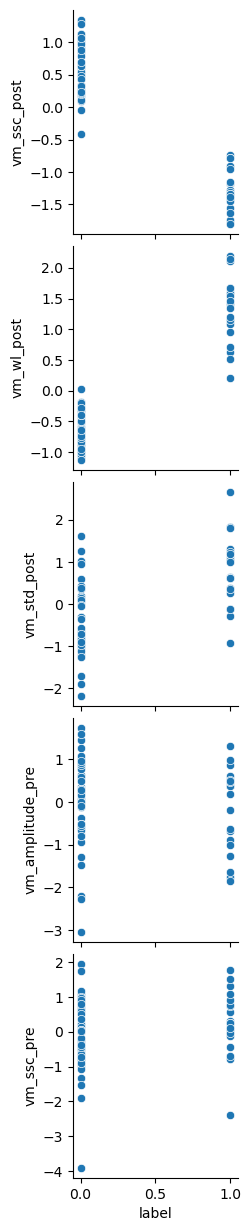

In [11]:
cell_id =  "TK471_1"
data_filtered = data_preproc[data_preproc['cell_id'] == cell_id].drop(columns=['cell_type', 'Cell_Anatomy', 'cell_id'])

sub_features = data_filtered.drop('label', axis=1).copy()
sub_labels = data_filtered['label'].copy()
features_strings = sub_features.columns.values

sub_features.reset_index(drop=True, inplace=True)
sub_labels.reset_index(drop=True, inplace=True)
top_features = df_single_cell_rfe[df_single_cell_rfe['cell_id'] == cell_id]['top_features'].iloc[0]
column_indices = [sub_features.columns.get_loc(col) for col in top_features]


scaler = StandardScaler()
X_z = scaler.fit_transform(sub_features.iloc[:, column_indices])
X_z = pd.DataFrame(X_z, columns=top_features)
X_z['label'] = sub_labels
sns.pairplot(data=X_z, x_vars=['label'], y_vars=top_features)

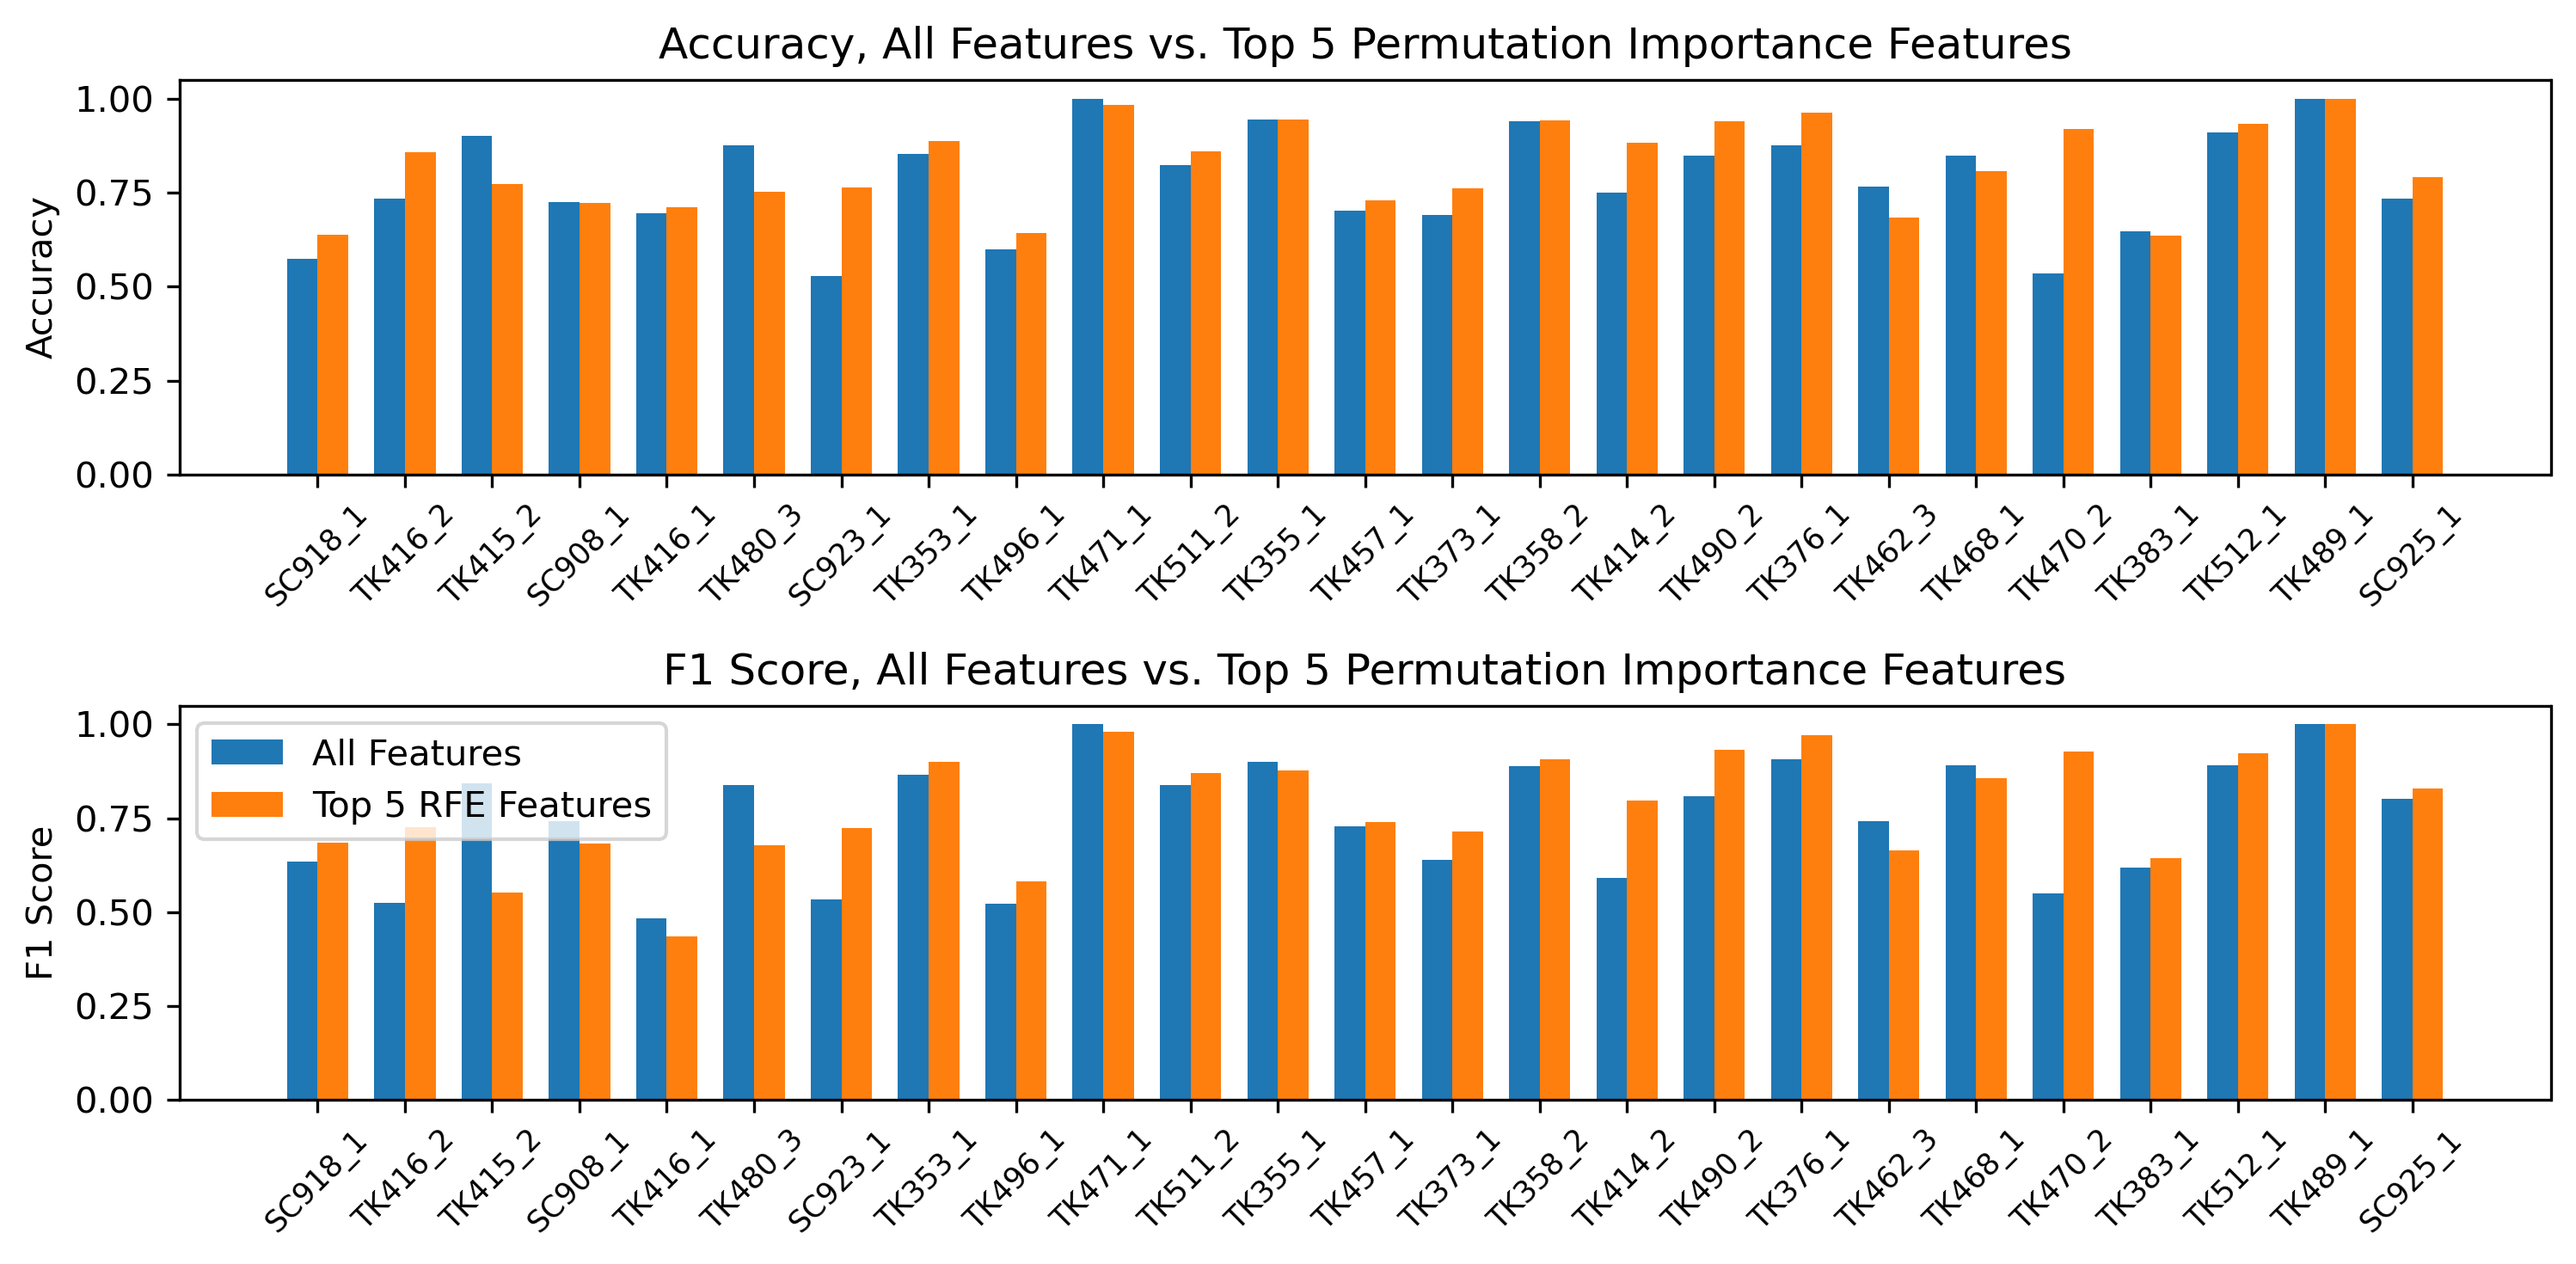

In [6]:
cell_type_labels = x_bar_plot

fig, axs = plt.subplots(2, 1, dpi=300, figsize=(10, 5))

bar_width = 0.35
index = np.arange(len(cell_type_labels))

axs[0].bar(index, df_single_cell_rfe['accuracy'], bar_width, label='All Features')
axs[0].bar(index + bar_width, df_single_cell_rfe['accuracy_with_top_features'], bar_width, label='Top 3 RFE Features')
axs[0].set_xticks(index + bar_width / 2)
axs[0].set_xticklabels(cell_type_labels, rotation=45, fontsize='small')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy, All Features vs. Top 5 Permutation Importance Features')

axs[1].bar(index, df_single_cell_rfe['f1'], bar_width, label='All Features')
axs[1].bar(index + bar_width, df_single_cell_rfe['f1_with_top_features'], bar_width, label='Top 5 RFE Features')
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(cell_type_labels, rotation=45, fontsize='small')
axs[1].set_ylabel('F1 Score')
axs[1].set_title('F1 Score, All Features vs. Top 5 Permutation Importance Features')




plt.tight_layout()
plt.legend()
plt.show()

# See if there's any correlation between the accuracy and anatomy

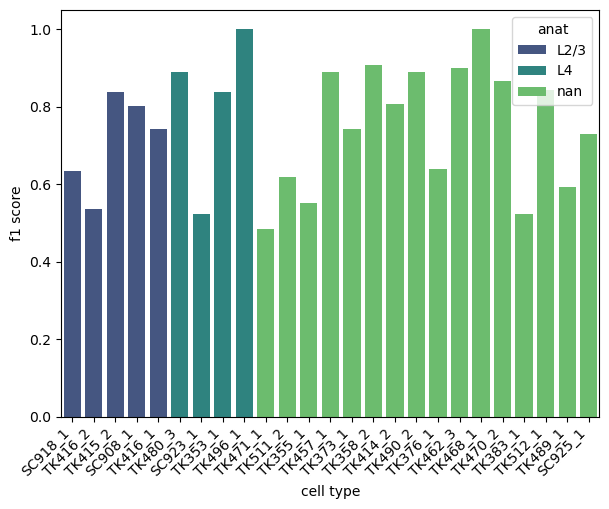

In [7]:
color = []
cell_anatomy_mapping = {'L2/3': 0, 'L4': 1, 'L5': 2, 'nan': 3}

df_single_cell_rfe.sort_values(by='anat', inplace=True)

color = df_single_cell_rfe["anat"]

plt.figure()
sns.barplot(x=x_bar_plot, y=df_single_cell_rfe["f1"], hue=color, palette="viridis")
plt.ylabel('f1 score')
plt.xlabel('cell type')
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()


# See if there's any correlation between the accuracy and barrel

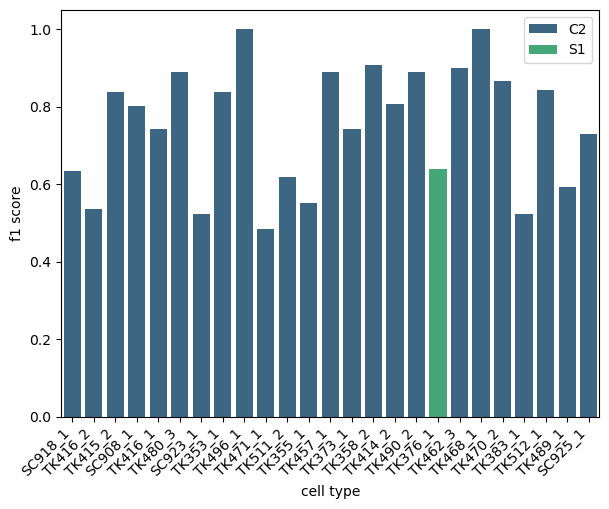

In [8]:
color = []
data_df = pd.read_pickle(os.path.join(data_path, fname))
for id in df_single_cell_rfe["cell_id"]:
    k = data_df[data_df["Cell_ID"] == id].iloc[0, 6]
    color.append(k)

plt.figure()
sns.barplot(x=x_bar_plot, y=df_single_cell_rfe["f1"], hue=color, palette="viridis")
plt.ylabel('f1 score')
plt.xlabel('cell type')
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

In [10]:
important_features_df_ranking = pd.DataFrame(list(df_single_cell_rfe['top_features']))
important_features_df_ranking.insert(0, 'cell_id', cell_type_labels)
important_features_df_ranking

cell_id            0                 1            2                  3  \
0   SC918_1     fft_high         vm_wl_pre   ap_fr_post        vm_std_post   
1   TK416_2  vm_std_post        vm_wl_post      fft_low        vm_ssc_post   
2   TK415_2   vm_ssc_pre       vm_std_post   ap_fr_post         vm_std_pre   
3   SC908_1  vm_ssc_post        vm_wl_post  vm_max_post          vm_wl_pre   
4   TK416_1     fft_high       vm_ssc_post   vm_ssc_pre        vm_max_post   
5   TK480_3   vm_ssc_pre        vm_wl_post  vm_std_post         ap_fr_post   
6   SC923_1   vm_ssc_pre       vm_ssc_post   vm_wl_post          ap_fr_pre   
7   TK353_1   vm_wl_post          fft_high   ap_fr_post        vm_std_post   
8   TK496_1   ap_fr_post       vm_ssc_post   vm_ssc_pre  vm_amplitude_post   
9   TK471_1   vm_wl_post         ap_fr_pre   vm_ssc_pre          vm_wl_pre   
10  TK511_2    vm_wl_pre          fft_high  vm_std_post            fft_low   
11  TK355_1   vm_wl_post        vm_ssc_pre   ap_fr_post           fft_high   
12  TK457_1   vm_ssc_pre        vm_wl_post  vm_std_post            fft_low   
13  TK373_1   vm_wl_post        vm_ssc_pre  vm_ssc_post            fft_low   
14  TK358_2     fft_high        vm_wl_post    ap_fr_pre        vm_max_post   
15  TK414_2   vm_wl_post       vm_std_post   vm_ssc_pre        vm_ssc_post   
16  TK490_2     fft_high        vm_wl_post  vm_ssc_post         ap_fr_post   
17  TK376_1     fft_high       vm_max_post   vm_wl_post        vm_ssc_post   
18  TK462_3   ap_fr_post  vm_amplitude_pre  vm_max_post          ap_fr_pre   
19  TK468_1  vm_ssc_post        vm_wl_post   vm_ssc_pre        vm_std_post   
20  TK470_2   vm_wl_post       vm_max_post  vm_ssc_post         vm_std_pre   
21  TK383_1  vm_ssc_post         vm_wl_pre   vm_std_pre         ap_fr_post   
22  TK512_1   vm_wl_post       vm_ssc_post   vm_max_pre          ap_fr_pre   
23  TK489_1  vm_max_post         ap_fr_pre   vm_wl_post          vm_wl_pre   
24  SC925_1  vm_std_post        vm_wl_post   vm_std_pre          vm_wl_pre   

                    4  
0          vm_wl_post  
1          vm_std_pre  
2         vm_max_post  
3          vm_mav_pre  
4          vm_std_pre  
5          vm_max_pre  
6          vm_max_pre  
7         vm_ssc_post  
8           ap_fr_pre  
9          vm_std_pre  
10        vm_ssc_post  
11         vm_max_pre  
12        vm_ssc_post  
13         ap_fr_post  
14         vm_ssc_pre  
15  vm_amplitude_post  
16         vm_ssc_pre  
17        vm_std_post  
18            fft_low  
19           fft_high  
20         vm_rms_pre  
21         vm_max_pre  
22         vm_ssc_pre  
23         vm_ssc_pre  
24        vm_ssc_post

# Assign scores to the features based on their rankings and sort them

Important Features: ['vm_wl_post', 'vm_ssc_post', 'vm_ssc_pre', 'fft_high', 'vm_std_post', 'ap_fr_post', 'vm_max_post', 'vm_wl_pre', 'ap_fr_pre', 'vm_std_pre', 'fft_low', 'vm_max_pre', 'vm_amplitude_pre', 'vm_amplitude_post', 'vm_mav_pre', 'vm_rms_pre']


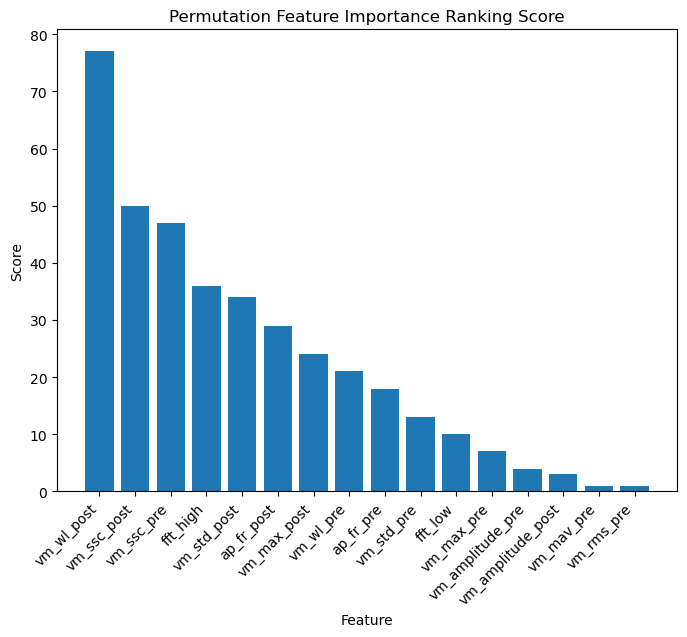

In [11]:
k = 5

top_feature_ranking = {}
for _, row in important_features_df_ranking.iterrows():
    for i in range(1, k+1):
        top_feature_ranking[row.iloc[i]]  = top_feature_ranking.get(row.iloc[i], 0) + (k-i+1)

top_feature_ranking =  dict(sorted(top_feature_ranking.items(), key=lambda item: item[1],  reverse=True))
print("Important Features:", list(top_feature_ranking.keys()))
plt.figure(figsize=(8, 6))
plt.bar(top_feature_ranking.keys(), top_feature_ranking.values())
plt.title(f'Permutation Feature Importance Ranking Score')
plt.xlabel("Feature")
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.show()

# Doing the same thing but only for SST

In [12]:
important_features_df_ranking = pd.DataFrame(list(df_single_cell_rfe['top_features']))
important_features_df_ranking.insert(0, 'cell_id', cell_type_labels)
classifiable_cellids_sst = data_preproc[(data_preproc["cell_id"].isin(classifiable_cellids)) & (data_preproc["cell_type"] == 3)]["cell_id"].unique()
important_features_df_ranking = important_features_df_ranking[important_features_df_ranking["cell_id"].isin(classifiable_cellids_sst)]
important_features_df_ranking

cell_id            0            1            2            3  \
1   TK416_2  vm_std_post   vm_wl_post      fft_low  vm_ssc_post   
7   TK353_1   vm_wl_post     fft_high   ap_fr_post  vm_std_post   
9   TK471_1   vm_wl_post    ap_fr_pre   vm_ssc_pre    vm_wl_pre   
11  TK355_1   vm_wl_post   vm_ssc_pre   ap_fr_post     fft_high   
13  TK373_1   vm_wl_post   vm_ssc_pre  vm_ssc_post      fft_low   
14  TK358_2     fft_high   vm_wl_post    ap_fr_pre  vm_max_post   
15  TK414_2   vm_wl_post  vm_std_post   vm_ssc_pre  vm_ssc_post   
16  TK490_2     fft_high   vm_wl_post  vm_ssc_post   ap_fr_post   
17  TK376_1     fft_high  vm_max_post   vm_wl_post  vm_ssc_post   
19  TK468_1  vm_ssc_post   vm_wl_post   vm_ssc_pre  vm_std_post   
20  TK470_2   vm_wl_post  vm_max_post  vm_ssc_post   vm_std_pre   
23  TK489_1  vm_max_post    ap_fr_pre   vm_wl_post    vm_wl_pre   

                    4  
1          vm_std_pre  
7         vm_ssc_post  
9          vm_std_pre  
11         vm_max_pre  
13         ap_fr_post  
14         vm_ssc_pre  
15  vm_amplitude_post  
16         vm_ssc_pre  
17        vm_std_post  
19           fft_high  
20         vm_rms_pre  
23         vm_ssc_pre

Important Features: ['vm_wl_post', 'fft_high', 'vm_ssc_post', 'vm_ssc_pre', 'vm_max_post', 'vm_std_post', 'ap_fr_pre', 'ap_fr_post', 'fft_low', 'vm_std_pre', 'vm_wl_pre', 'vm_max_pre', 'vm_amplitude_post', 'vm_rms_pre']


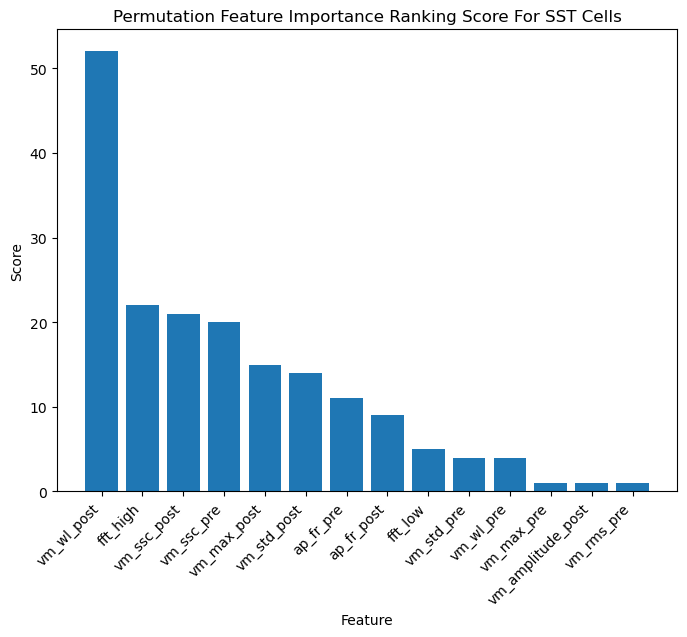

In [13]:
k = 5

top_feature_ranking = {}
for _, row in important_features_df_ranking.iterrows():
    for i in range(1, k+1):
        top_feature_ranking[row.iloc[i]]  = top_feature_ranking.get(row.iloc[i], 0) + (k-i+1)

top_feature_ranking =  dict(sorted(top_feature_ranking.items(), key=lambda item: item[1],  reverse=True))
print("Important Features:", list(top_feature_ranking.keys()))
plt.figure(figsize=(8, 6))
plt.bar(top_feature_ranking.keys(), top_feature_ranking.values())
plt.title(f'Permutation Feature Importance Ranking Score For SST Cells')
plt.xlabel("Feature")
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.show()